In [65]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime
import ast
from decimal import Decimal, ROUND_UP
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import altair as alt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose as s_dec
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from collections import defaultdict

In [2]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [63]:
def normalize_ts (metric_to_normalize):
    
    values = metric_to_normalize.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)

    return normalized

In [3]:
def simple_plot (index, values=None, title_plot=None, save=None):
    
    if values is None:
        values=index
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(index.index, values)
    
    if title_plot is not None:
        fig.suptitle(title_plot, fontsize=18)

    ax.grid(True)
    
    ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.xlabel('year', fontsize=16)
    plt.ylabel('values', fontsize=16)

    if save:
        title = title_plot.replace(" ", "_") + "png"
        plt.savefig(title, dpi = 300, facecolor='w')
               
    plt.show()
    

    
def decomposition_plot (metric, trend, seasonal, residual, title, save=None):

    fig, ax = plt.subplots (4, sharex=True, figsize = (20,10))
    
    fig.suptitle(title, fontsize=20)
    
    ax[0].plot(metric)
    ax[0].set(title="Original")
    ax[0].grid()
    
    
    ax[1].plot(trend)
    ax[1].set(title="Trend")
    ax[1].grid()
    
    ax[2].plot(seasonal)
    ax[2].set(title="Seasonality")
    ax[2].grid()
    
    ax[3].plot(residual)
    ax[3].set(title="Residual")
    ax[3].grid()
    ax[3].set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])
    
    plt.xticks(fontsize=13)
    
    if save:
        title = title_plot.replace(" ", "_") + "png"
        plt.savefig(title, dpi = 300, facecolor='w')
    
    plt.show()
    
    
def line_trend_plot (index, trend_index, values=None, trend_values=None, title_plot=None, save=None):

    if values is None:
        values=index
    
    if trend_values is None:
        trend_values=trend_index
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.grid(True)
    
    if title_plot is not None:
        fig.suptitle(title_plot, fontsize=18)

    year = mdates.YearLocator(month=1)
    month = mdates.MonthLocator(interval=3)

    ax.xaxis.set_minor_locator(month)
    ax.xaxis.set_major_locator(year)
    ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

    plt.plot(index.index, values, linewidth=2)
    plt.plot(trend_index.index, trend_values, c='red', linewidth=2)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel('year', fontsize=15)
    plt.ylabel('values', fontsize=15)

    if save:
        title = title_plot.replace(" ", "_") + "png"
        plt.savefig(title, dpi = 300, facecolor='w')

    plt.show()

In [4]:
PATH = 'cleaned_df_v2.csv'

In [5]:
df = pd.read_csv(PATH, sep=";", index_col=False)

In [6]:
df['date_chart'] = pd.to_datetime(df['date_chart'], format= '%Y-%m-%d')
df['year'] = df['date_chart'].dt.year
df['month'] = df['date_chart'].dt.month

In [7]:
df = df.set_index("date_chart")
df.head()

original_song_name original_artists_name  curr_rank tag_fimi  \
date_chart                                                                    
2006-05-07  svegliarsi la mattina         zero assoluto          1      sgo   
2006-05-14  svegliarsi la mattina         zero assoluto          3      sgo   
2006-05-21  svegliarsi la mattina         zero assoluto          3      sgo   
2006-05-28  svegliarsi la mattina         zero assoluto          4      sgo   
2006-06-04  svegliarsi la mattina         zero assoluto          4      sgo   

           publisher  song_id album_release_date album_type  \
date_chart                                                    
2006-05-07       NaN        0         2006-02-28     single   
2006-05-14       NaN        0         2006-02-28     single   
2006-05-21       NaN        0         2006-02-28     single   
2006-05-28       NaN        0         2006-02-28     single   
2006-06-04       NaN        0         2006-02-28     single   

                        song_name                album_id  ...   tempo  \
date_chart                                                 ...           
2006-05-07  Svegliarsi la mattina  6d1AvZ3brZ9caD2cFbIbbd  ...  171.97   
2006-05-14  Svegliarsi la mattina  6d1AvZ3brZ9caD2cFbIbbd  ...  171.97   
2006-05-21  Svegliarsi la mattina  6d1AvZ3brZ9caD2cFbIbbd  ...  171.97   
2006-05-28  Svegliarsi la mattina  6d1AvZ3brZ9caD2cFbIbbd  ...  171.97   
2006-06-04  Svegliarsi la mattina  6d1AvZ3brZ9caD2cFbIbbd  ...  171.97   

                      type                      id  \
date_chart                                           
2006-05-07  audio_features  1ecMdfIXNksJTymYlzsFZ3   
2006-05-14  audio_features  1ecMdfIXNksJTymYlzsFZ3   
2006-05-21  audio_features  1ecMdfIXNksJTymYlzsFZ3   
2006-05-28  audio_features  1ecMdfIXNksJTymYlzsFZ3   
2006-06-04  audio_features  1ecMdfIXNksJTymYlzsFZ3   

                                                          uri  \
date_chart                                                      
2006-05-07  https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
2006-05-14  https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
2006-05-21  https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
2006-05-28  https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
2006-06-04  https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   

                                                   track_href  analysis_url  \
date_chart                                                                    
2006-05-07  https://api.spotify.com/v1/audio-analysis/1ecM...        223053   
2006-05-14  https://api.spotify.com/v1/audio-analysis/1ecM...        223053   
2006-05-21  https://api.spotify.com/v1/audio-analysis/1ecM...        223053   
2006-05-28  https://api.spotify.com/v1/audio-analysis/1ecM...        223053   
2006-06-04  https://api.spotify.com/v1/audio-analysis/1ecM...        223053   

            duration_ms  time_signature  year  month  
date_chart                                            
2006-05-07            4             NaN  2006      5  
2006-05-14            4             NaN  2006      5  
2006-05-21            4             NaN  2006      5  
2006-05-28            4             NaN  2006      5  
2006-06-04            4             NaN  2006      6  

[5 rows x 35 columns]

In [8]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#df = pd.read_csv(PATH, sep=";", parse_dates=True, index_col='date_chart', date_parser=dateparse)
#df.head()

**Variabili

In [16]:
song_number, explicit, number_artists, valence, danceability, duration, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, tempo  = df['id'], df['explicit'], df['artists_id'], df['valence'], df['danceability'], df['duration'], df['energy'], df['loudness'], df['mode'], df['speechiness'], df['acousticness'], df['instrumentalness'], df['liveness'], df['tempo']

song_number = song_number.resample("Y").count()

number_artists = number_artists.transform(ast.literal_eval).str.len()
number_artists = number_artists.resample("M").mean()
    
explicit = explicit.resample("M").sum()/explicit.resample('M').count()

valence = valence.resample("M").mean()
danceability = danceability.resample("M").mean()
duration = duration.resample("M").mean()
energy = energy.resample("M").mean()
loudness = loudness.resample("M").mean()
mode = mode.resample("M").mean()
speechiness = speechiness.resample("M").mean()
acousticness = acousticness.resample("M").mean()
instrumentalness = instrumentalness.resample("M").mean()
liveness = liveness.resample("M").mean()
tempo = tempo.resample("M").mean() 

**Filter only the Covid's period and from 2012 to today

In [17]:
covid_time = df.loc[df.index > '2019-03-01']

In [18]:
covid_valence, covid_danceability, covid_duration, covid_energy, covid_loudness, covid_mode, covid_speechiness, covid_acousticness, covid_instrumentalness, covid_liveness, covid_tempo  = covid_time['valence'], covid_time['danceability'], covid_time['duration'], covid_time['energy'], covid_time['loudness'], covid_time['mode'], covid_time['speechiness'], covid_time['acousticness'], covid_time['instrumentalness'], covid_time['liveness'], covid_time['tempo']

covid_valence = covid_valence.resample("M").mean()
covid_danceability = covid_danceability.resample("M").mean()
covid_duration = covid_duration.resample("M").mean()
covid_energy = covid_energy.resample("M").mean()
covid_loudness = covid_loudness.resample("M").mean()
covid_mode = covid_mode.resample("M").mean()
covid_speechiness = covid_speechiness.resample("M").mean()
covid_acousticness = covid_acousticness.resample("M").mean()
covid_instrumentalness = covid_instrumentalness.resample("M").mean()
covid_liveness = covid_liveness.resample("M").mean()
covid_tempo = covid_tempo.resample("M").mean()

**Dal 2012 al 2021

In [19]:
count_time = df.loc[(df.index > '2012-01-01') & (df.index < '2021-01-01')]

#### Decompositions

In [21]:
dec_number_artists, dec_duration, dec_valence, dec_danceability, dec_energy, dec_loudness, dec_mode, dec_speechiness = s_dec(number_artists), s_dec(duration), s_dec(valence), s_dec(danceability), s_dec(energy), s_dec(loudness), s_dec(mode), s_dec(speechiness)
dec_explicit, dec_acousticness, dec_instrumentalness, dec_liveness, dec_tempo = s_dec(explicit), s_dec(acousticness), s_dec(instrumentalness), s_dec(liveness), s_dec(tempo)

trend_number_artists, trend_duration, trend_explicit, trend_valence, trend_danceability, trend_energy, trend_loudness = dec_number_artists.trend, dec_duration.trend, dec_explicit.trend, dec_valence.trend, dec_danceability.trend, dec_energy.trend, dec_loudness.trend
trend_mode, trend_speechiness, trend_acousticness, trend_instrumentalness, trend_liveness, trend_tempo = dec_mode.trend, dec_speechiness.trend, dec_acousticness.trend, dec_instrumentalness.trend, dec_liveness.trend, dec_tempo.trend

seasonal_number_artists, seasonal_duration, seasonal_explicit, seasonal_valence, seasonal_danceability, seasonal_energy, seasonal_loudness = dec_number_artists.seasonal, dec_duration.seasonal, dec_explicit.seasonal, dec_valence.seasonal, dec_danceability.seasonal, dec_energy.seasonal, dec_loudness.seasonal    
seasonal_mode, seasonal_speechiness, seasonal_acousticness, seasonal_instrumentalness, seasonal_liveness, seasonal_tempo = dec_mode.seasonal, dec_speechiness.seasonal, dec_acousticness.seasonal, dec_instrumentalness.seasonal, dec_liveness.seasonal, dec_tempo.seasonal

residual_number_artists, residual_duration, residual_explicit, residual_valence, residual_danceability, residual_energy, residual_loudness = dec_number_artists.resid, dec_duration.resid, dec_explicit.resid, dec_valence.resid, dec_danceability.resid, dec_energy.resid, dec_loudness.resid    
residual_mode, residual_speechiness, residual_acousticness, residual_instrumentalness, residual_liveness, residual_tempo = dec_mode.resid, dec_speechiness.resid, dec_acousticness.resid, dec_instrumentalness.resid, dec_liveness.resid, dec_tempo.resid 

# Number of songs

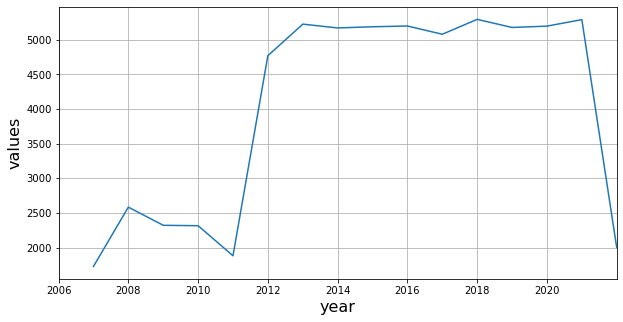

In [23]:
simple_plot (song_number)

# Number of artists

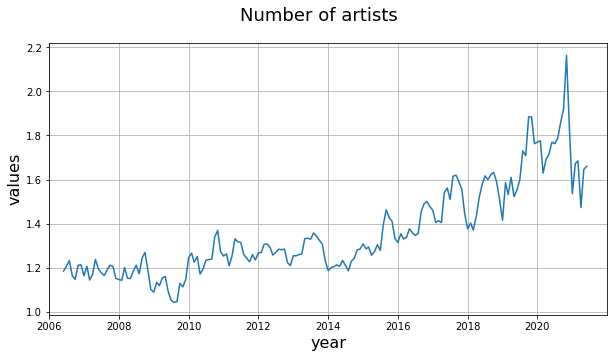

In [25]:
simple_plot (number_artists, title_plot="Number of artists")

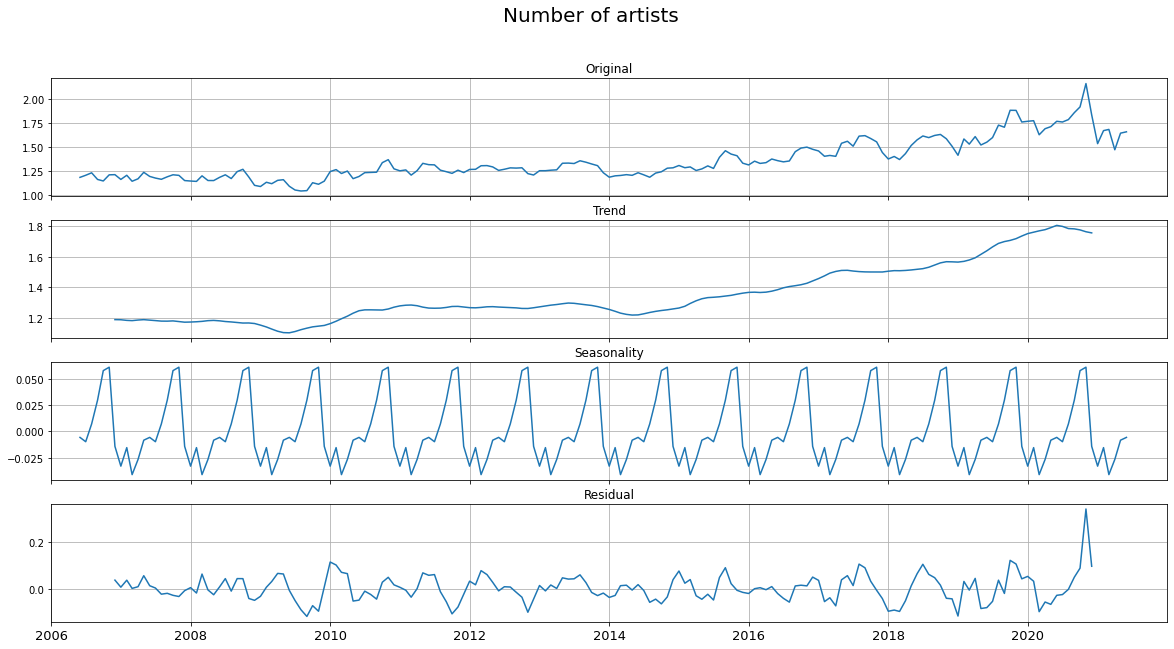

In [27]:
decomposition_plot (number_artists, trend_number_artists, seasonal_number_artists, residual_number_artists, "Number of artists")

# Most frequent artists

#### Da fare

# Explicit

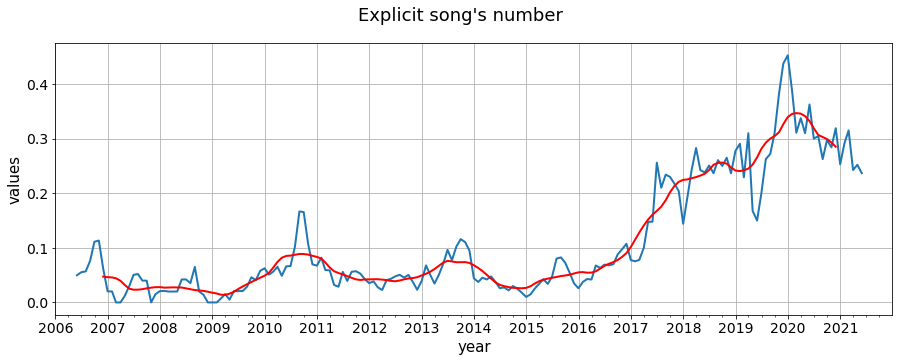

In [29]:
line_trend_plot (explicit, trend_explicit, title_plot="Explicit song's number")

# Duration

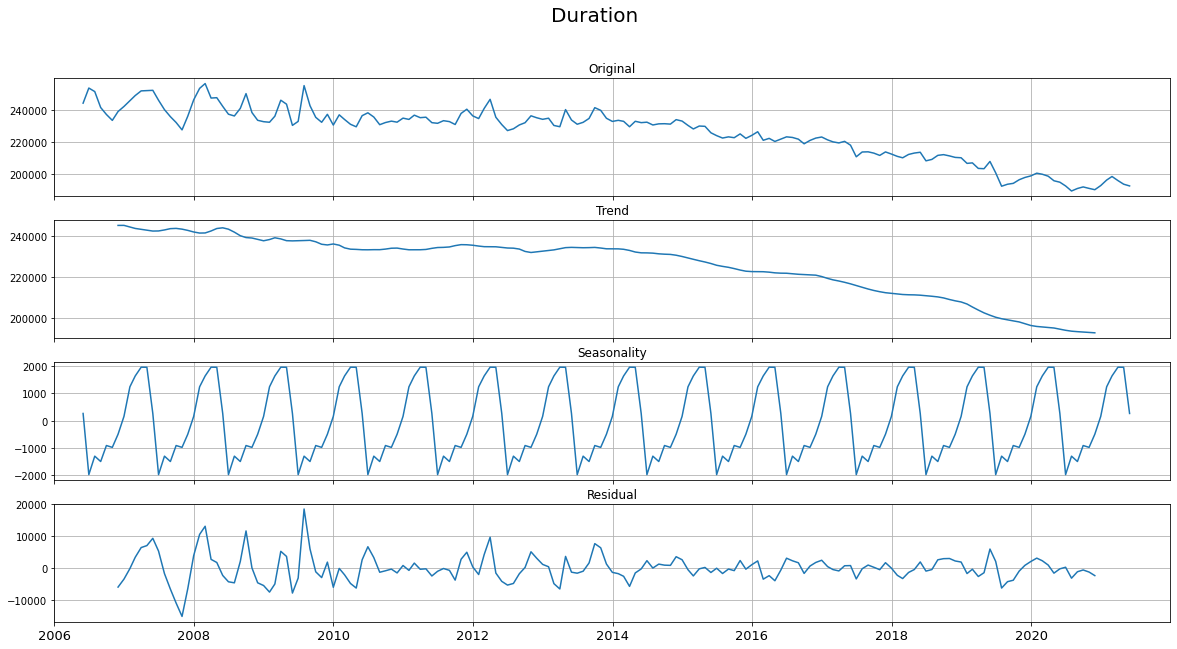

In [30]:
decomposition_plot(duration, trend_duration, seasonal_duration, residual_duration, "Duration")

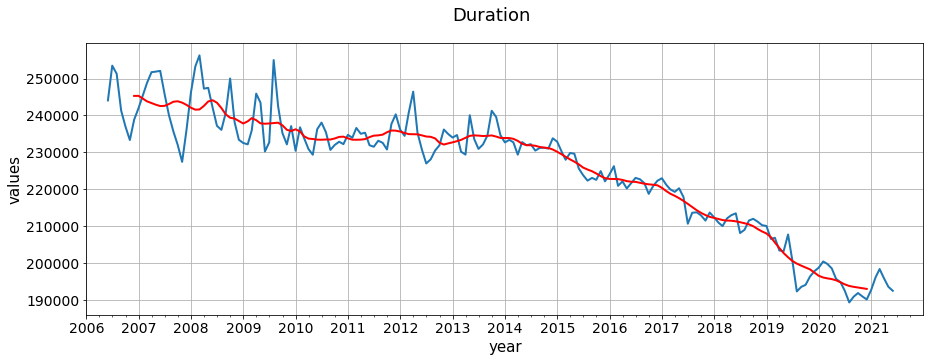

In [32]:
line_trend_plot (duration, trend_duration, title_plot= "Duration")

# Valence

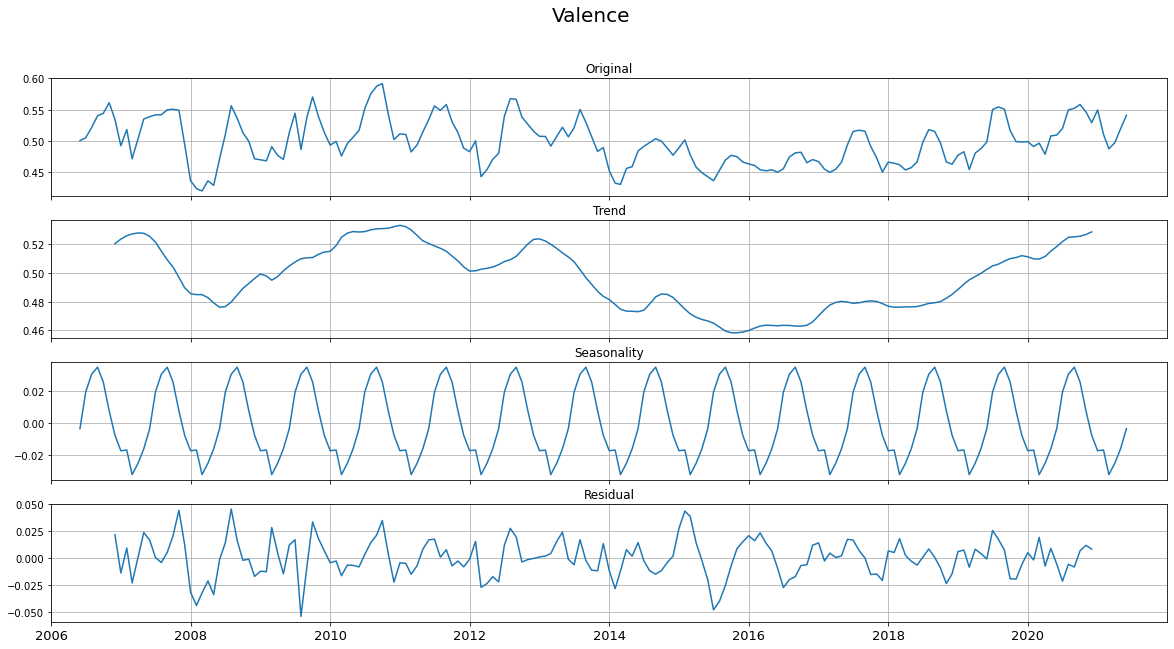

In [33]:
decomposition_plot (valence, trend_valence, seasonal_valence, residual_valence, "Valence")

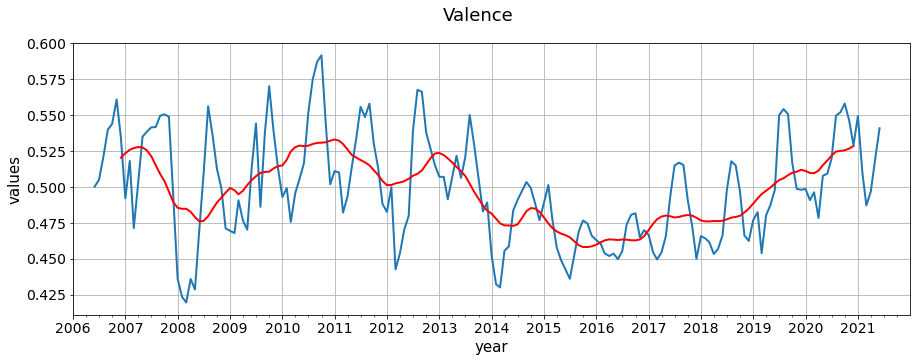

In [35]:
line_trend_plot (valence, trend_valence, title_plot = "Valence")

## Danceability

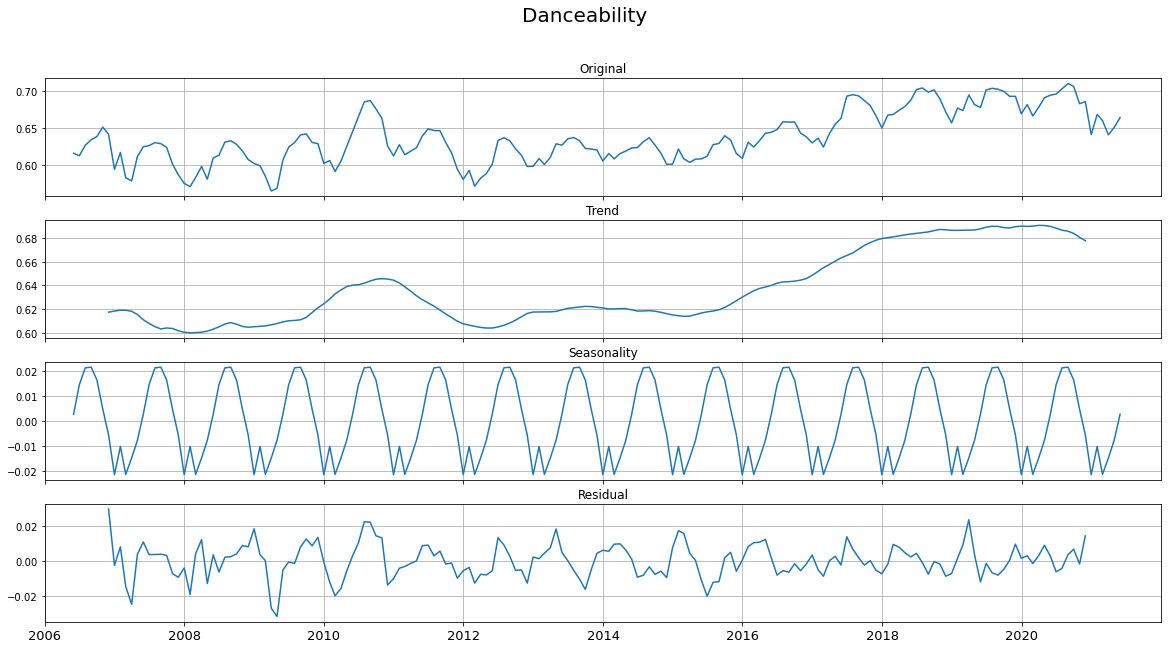

In [36]:
decomposition_plot (danceability, trend_danceability, seasonal_danceability, residual_danceability, "Danceability")

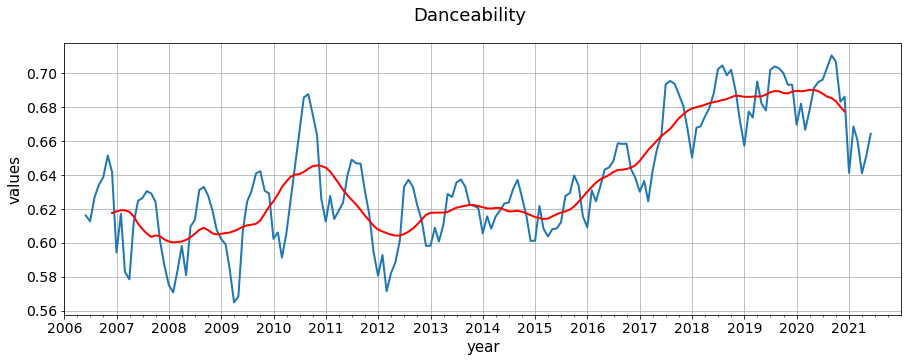

In [37]:
line_trend_plot (danceability, trend_danceability, title_plot = "Danceability")

# Energy

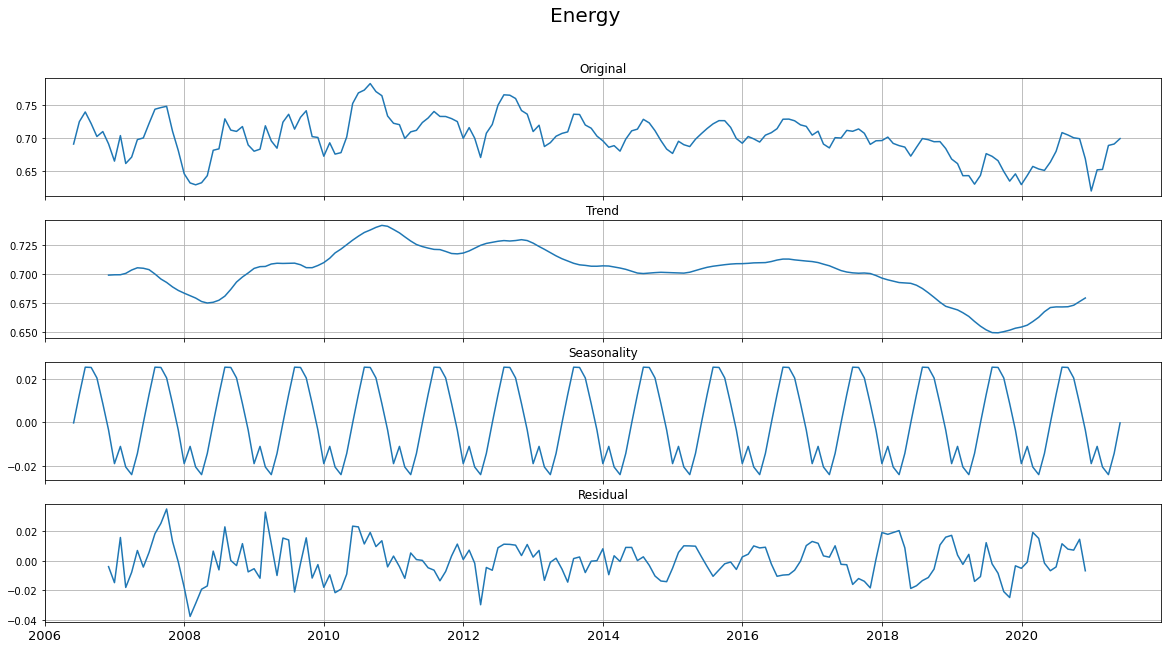

In [39]:
decomposition_plot (energy, trend_energy, seasonal_energy, residual_energy, "Energy")

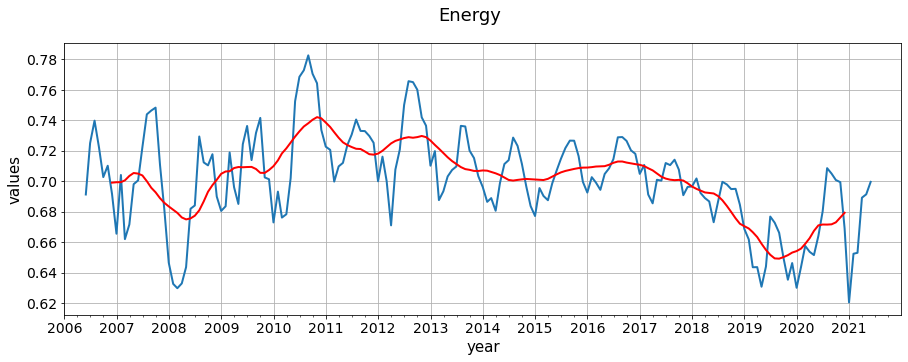

In [40]:
line_trend_plot (energy, trend_energy, title_plot = "Energy")

# Loudness

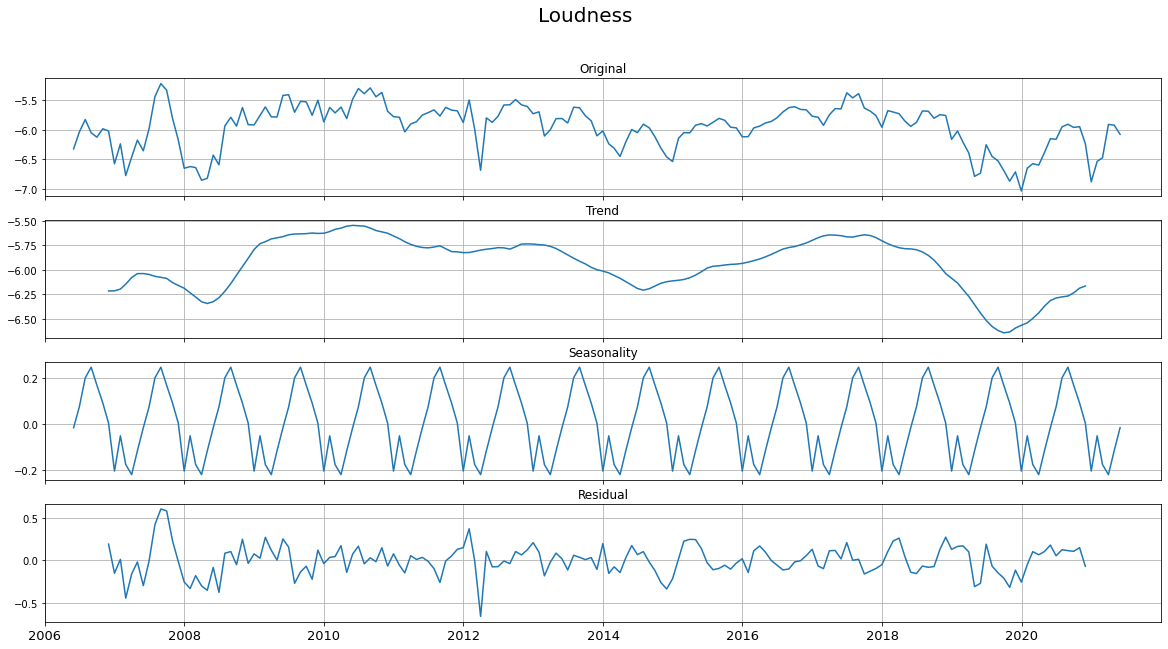

In [41]:
decomposition_plot (loudness, trend_loudness, seasonal_loudness, residual_loudness, "Loudness")

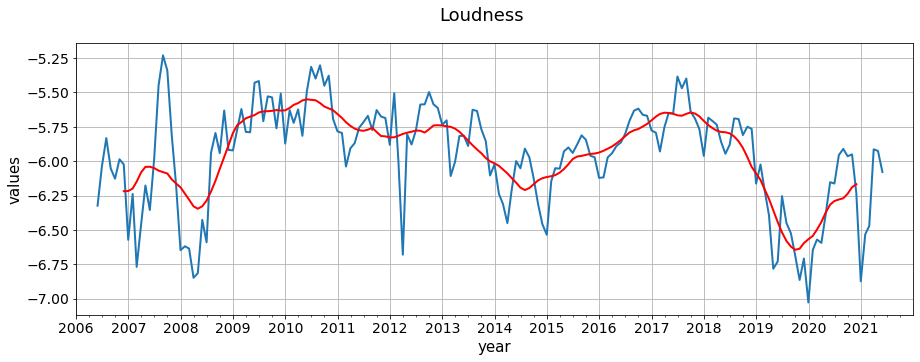

In [43]:
line_trend_plot (loudness, trend_loudness, title_plot = "Loudness")

# Mode

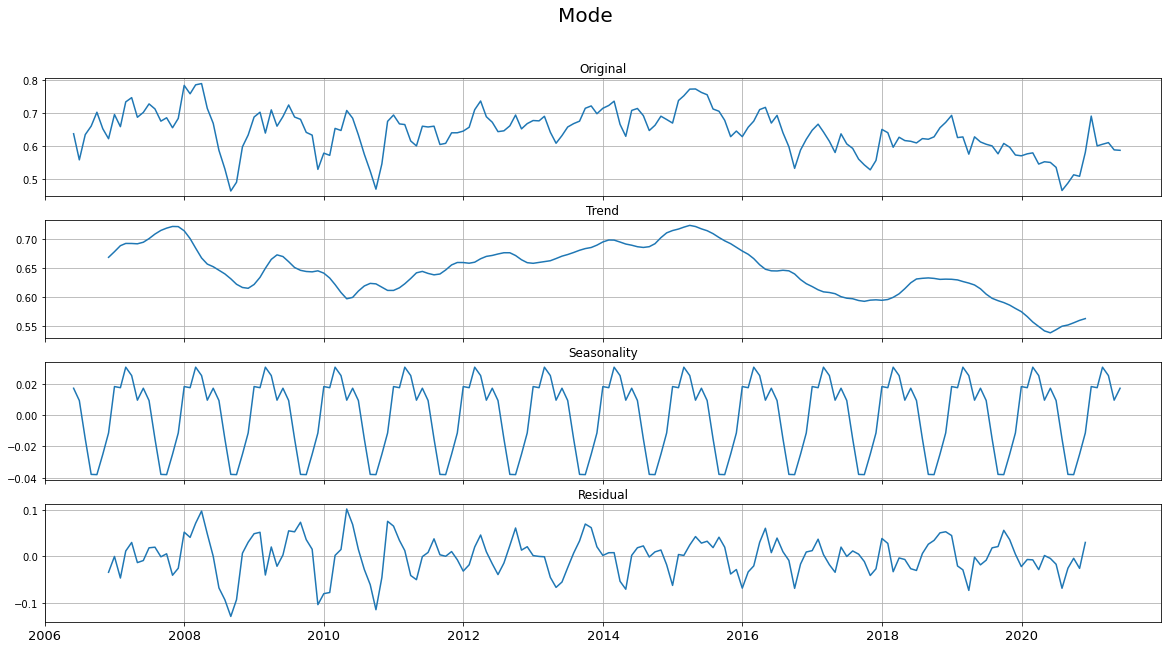

In [44]:
decomposition_plot (mode, trend_mode, seasonal_mode, residual_mode, "Mode")

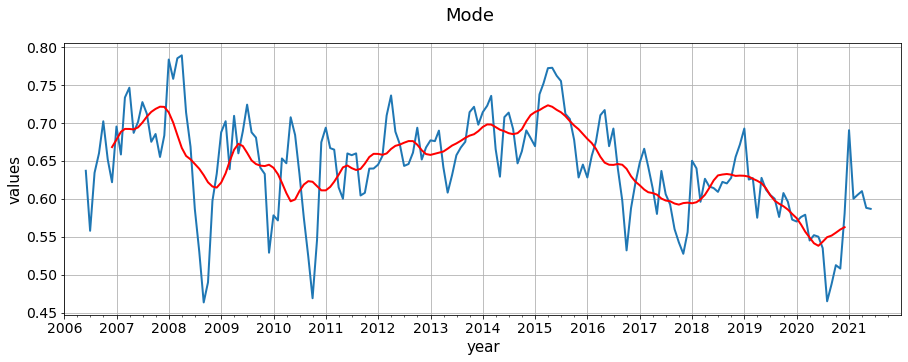

In [46]:
line_trend_plot (mode, trend_mode, title_plot = "Mode")

# Speechiness

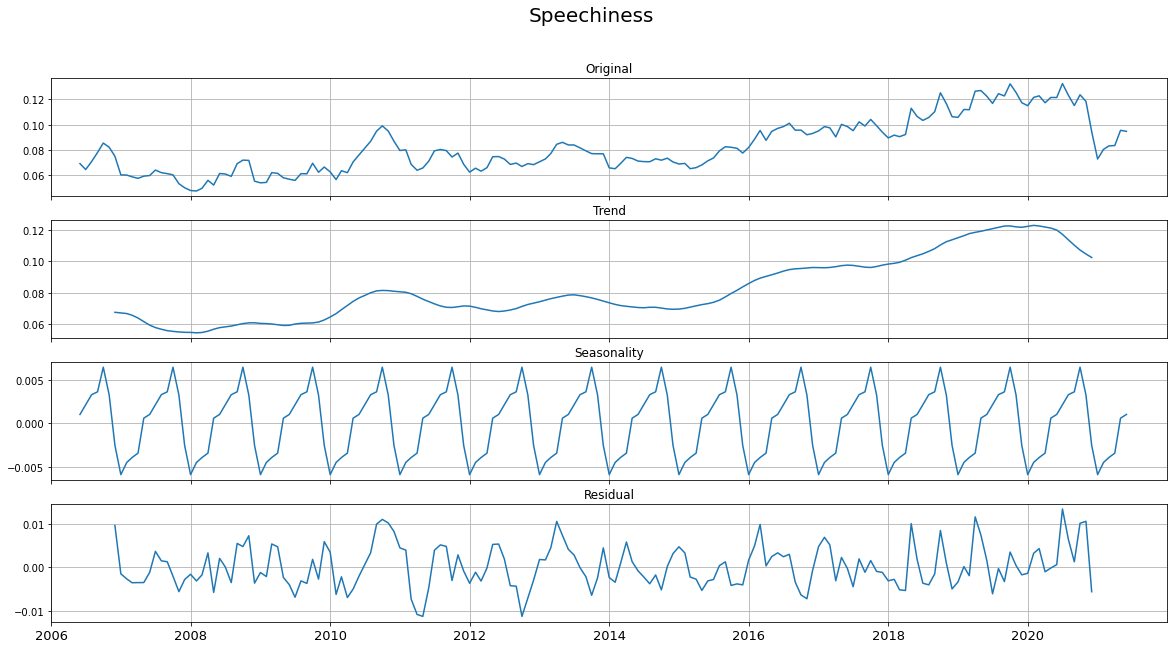

In [47]:
decomposition_plot (speechiness, trend_speechiness, seasonal_speechiness, residual_speechiness, "Speechiness")

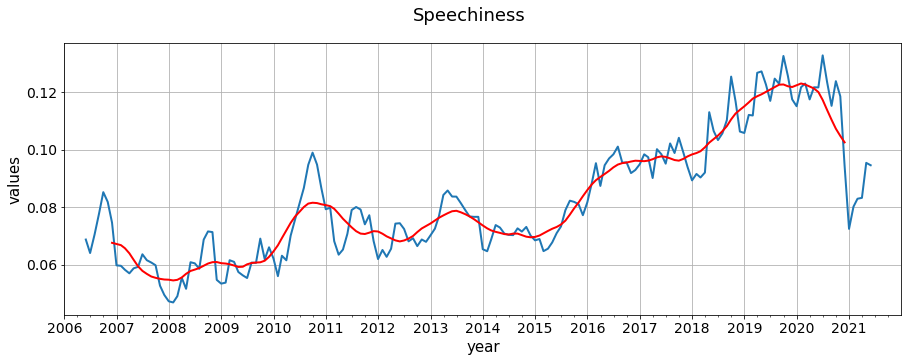

In [49]:
line_trend_plot (speechiness, trend_speechiness, title_plot = "Speechiness")

# Acousticness

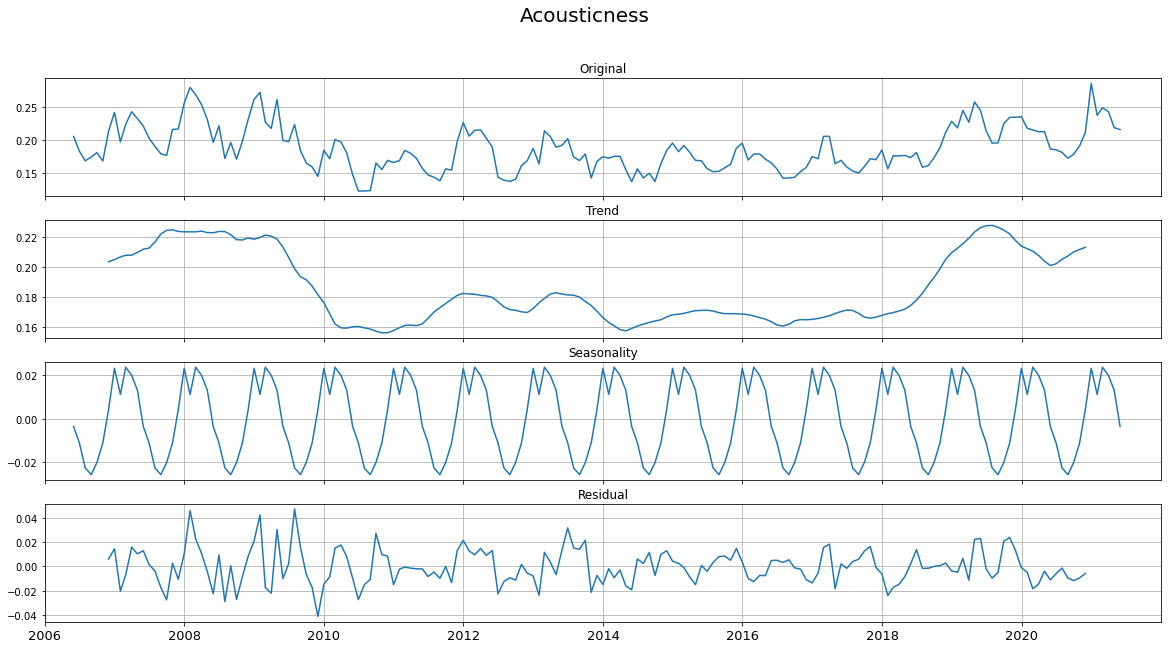

In [50]:
decomposition_plot (acousticness, trend_acousticness, seasonal_acousticness, residual_acousticness, "Acousticness")

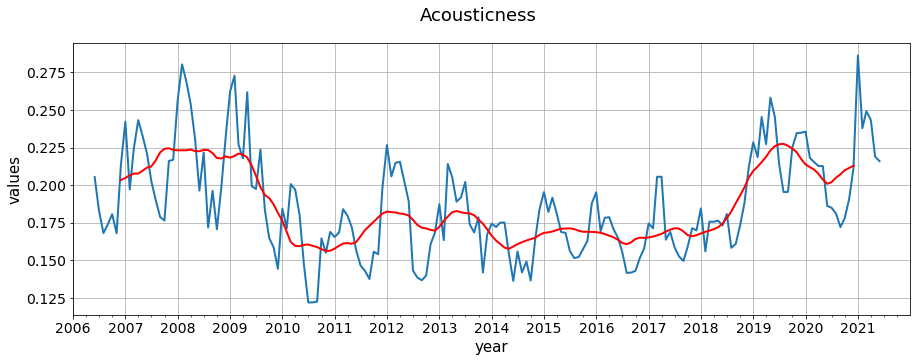

In [52]:
line_trend_plot (acousticness, trend_acousticness, title_plot = "Acousticness")

# Instrumentalness

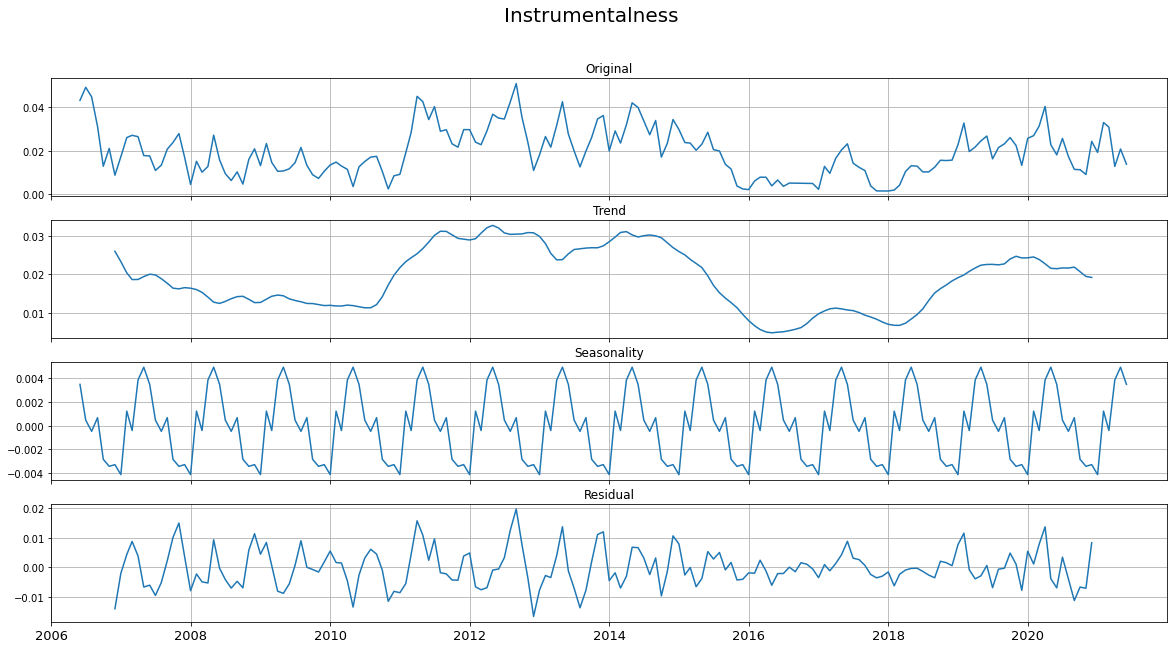

In [53]:
decomposition_plot (instrumentalness, trend_instrumentalness, seasonal_instrumentalness, residual_instrumentalness, "Instrumentalness")

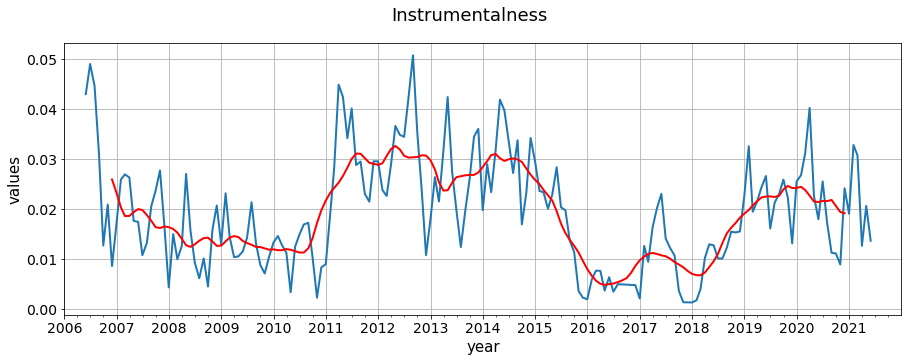

In [55]:
line_trend_plot (instrumentalness, trend_instrumentalness, title_plot = "Instrumentalness")

# Liveness

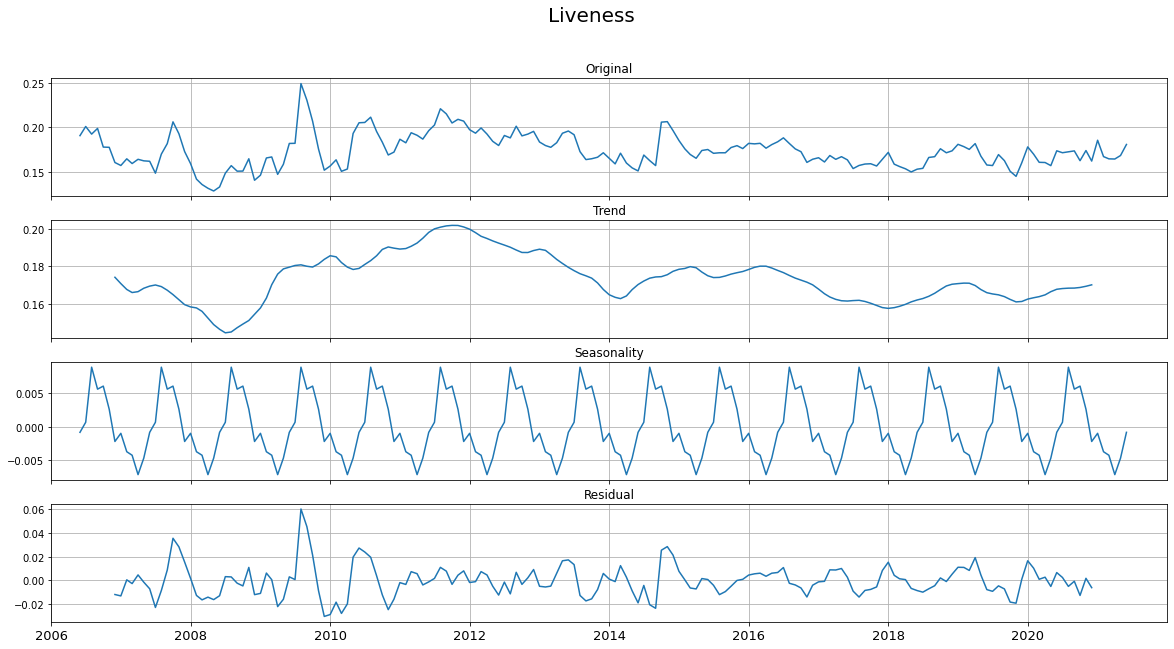

In [56]:
decomposition_plot (liveness, trend_liveness, seasonal_liveness, residual_liveness, "Liveness")

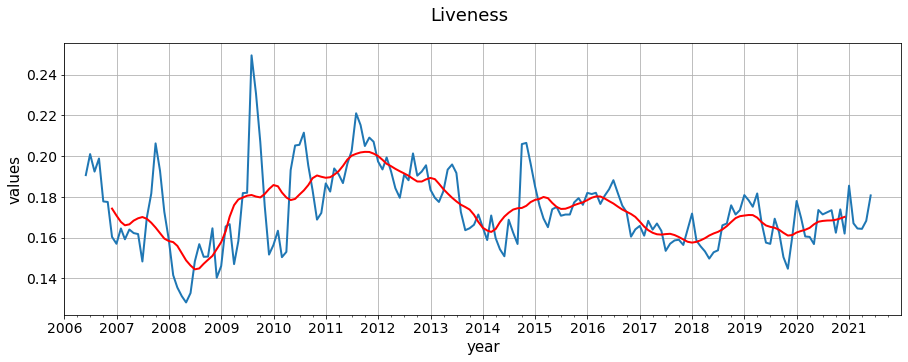

In [58]:
line_trend_plot (liveness, trend_liveness, title_plot = "Liveness")

# Tempo

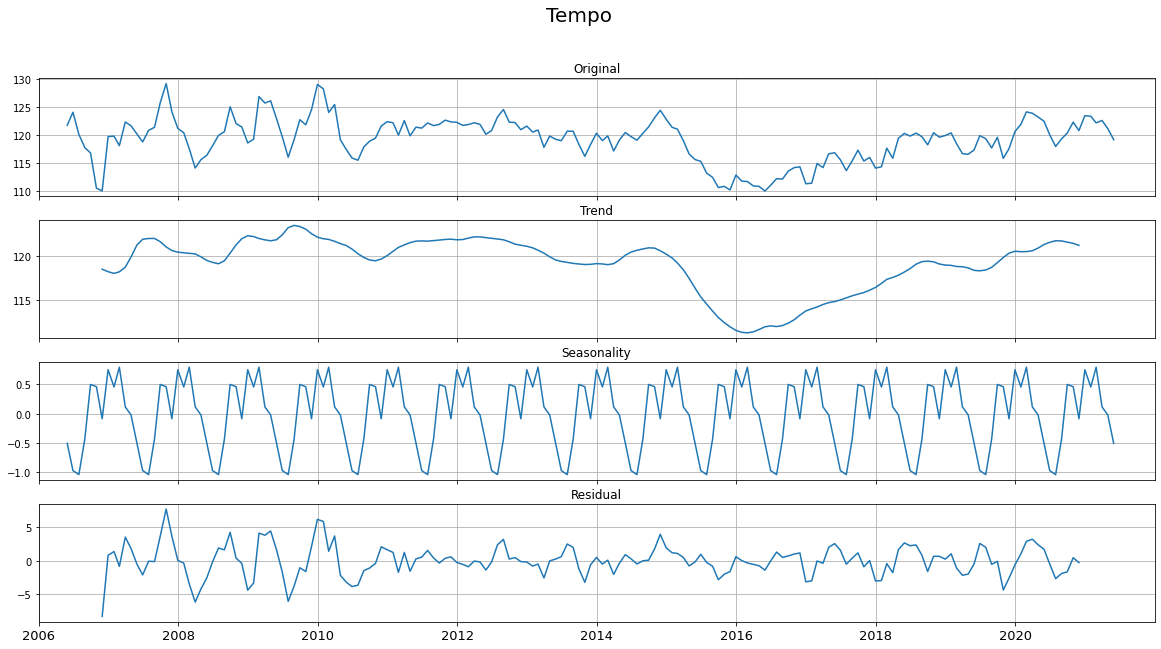

In [59]:
decomposition_plot (tempo, trend_tempo, seasonal_tempo, residual_tempo, "Tempo")

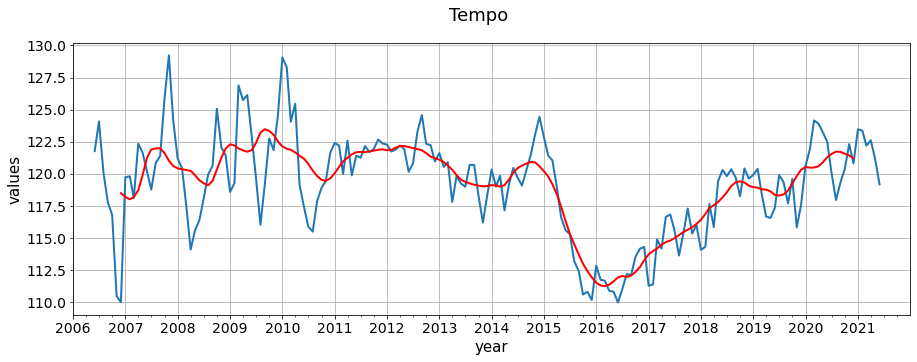

In [61]:
line_trend_plot (tempo, trend_tempo, title_plot = "Tempo")

# Example of normalized plot

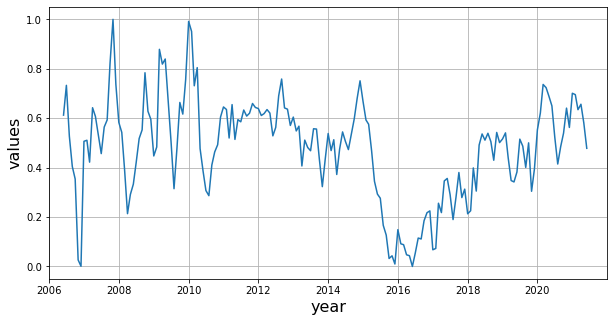

In [67]:
simple_plot (index = tempo, values = normalize_ts(tempo))

# GRAFICI

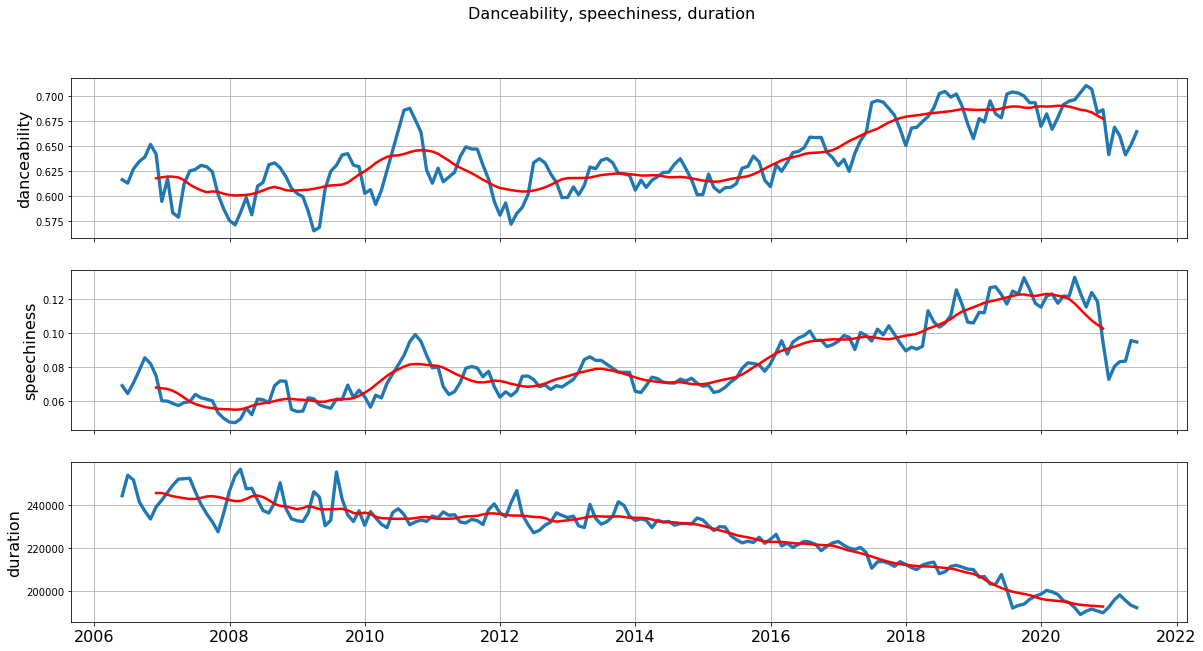

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))


fig.suptitle('Danceability, speechiness, duration', fontsize=16)


ax1.plot(danceability, label='danceability', linewidth=3.3)
ax1.grid(True)
ax1.set_ylabel('danceability',fontsize=16)
ax1.plot(trend_danceability.index, trend_danceability, c='red', linewidth=2.5)

ax2.plot(speechiness, label='speechiness', linewidth=3.3)
ax2.grid(True)
ax2.set_ylabel('speechiness',fontsize=16)
ax2.plot(trend_speechiness.index, trend_speechiness, c='red', linewidth=2.5)

ax3.plot(duration, label='duration', linewidth=3.3)
ax3.grid(True)
ax3.set_ylabel('duration', fontsize=16)
ax3.set_ylabel('duration',fontsize=16)
ax3.plot(trend_duration.index, trend_duration, c='red', linewidth=2.5)


plt.xticks(fontsize=16)

plt.show()

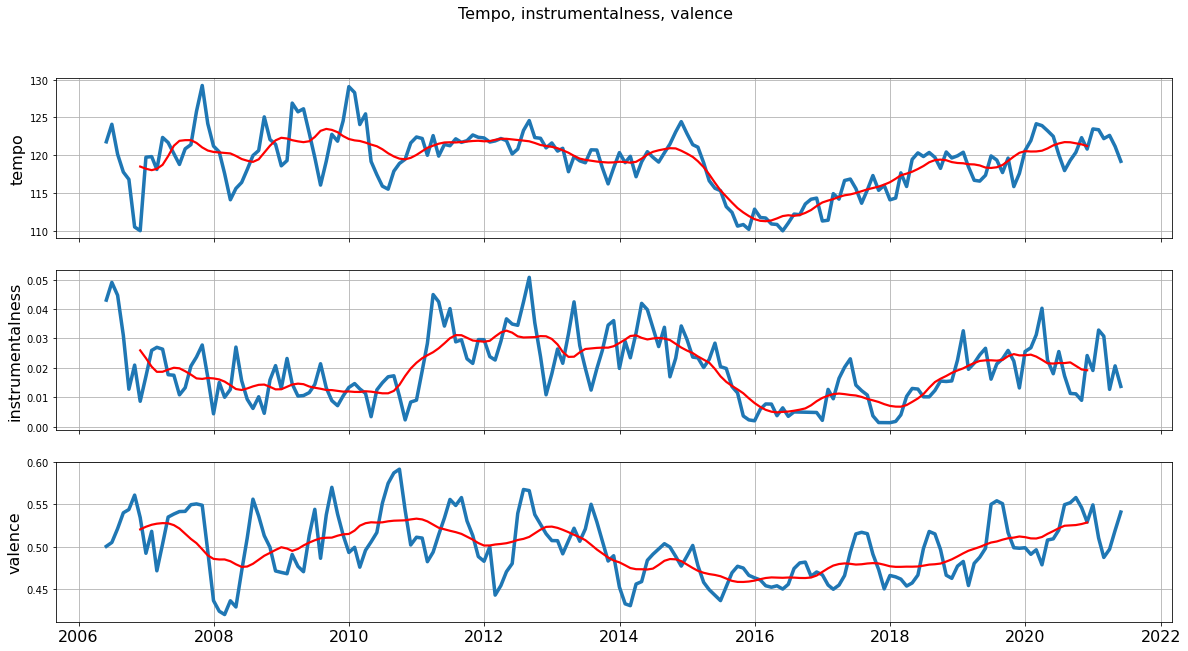

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))


fig.suptitle('Tempo, instrumentalness, valence', fontsize=16)


ax1.plot(tempo, label='tempo', linewidth=3.5)
ax1.grid(True)
ax1.set_ylabel('tempo',fontsize=16)
ax1.set_ylabel('tempo',fontsize=16)
ax1.plot(trend_tempo.index, trend_tempo, c='red', linewidth=2.2)

ax2.plot(instrumentalness, label='instrumentalness', linewidth=3.5)
ax2.grid(True)
ax2.set_ylabel('instrumentalness',fontsize=16)
ax2.plot(trend_instrumentalness.index, trend_instrumentalness, c='red', linewidth=2.2)

ax3.plot(valence, label='valence', linewidth=3.5)
ax3.grid(True)
ax3.set_ylabel('valence', fontsize=16)
ax3.set_ylabel('valence',fontsize=16)
ax3.plot(trend_valence.index, trend_valence, c='red', linewidth=2.2)

plt.xticks(fontsize=16)

plt.show()

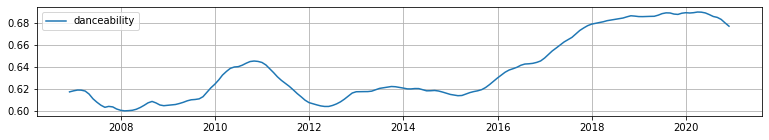

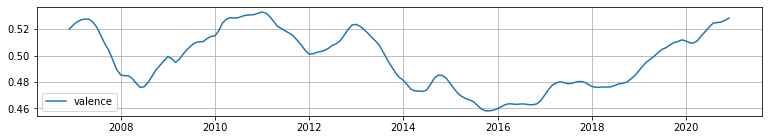

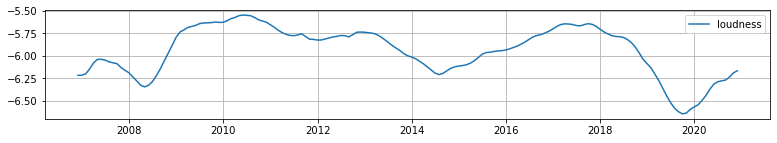

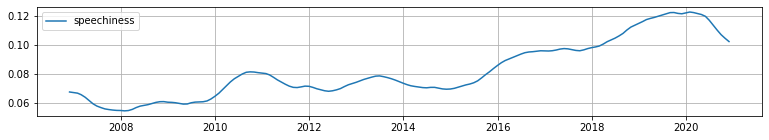

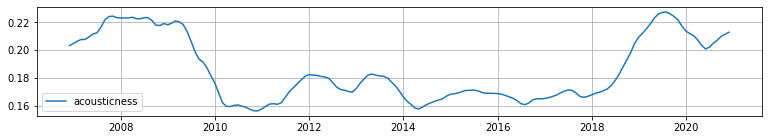

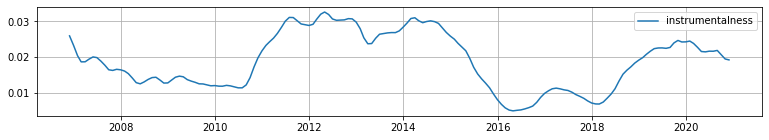

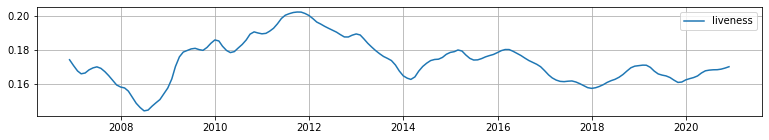

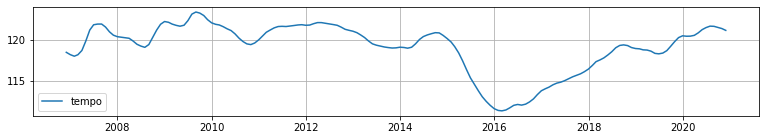

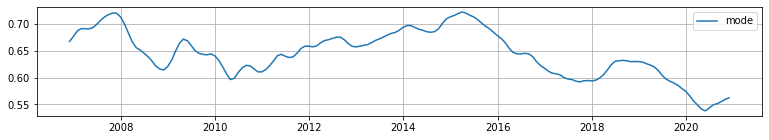

In [72]:
fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_danceability, label='danceability')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_valence, label='valence')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_loudness, label='loudness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_speechiness, label='speechiness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_acousticness, label='acousticness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_instrumentalness, label='instrumentalness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_liveness, label='liveness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_tempo, label='tempo')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_mode, label='mode')
plt.legend(loc='best')

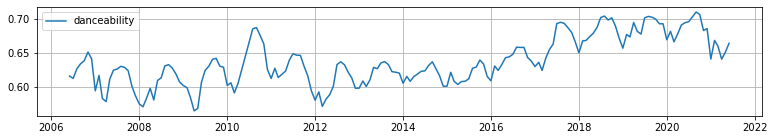

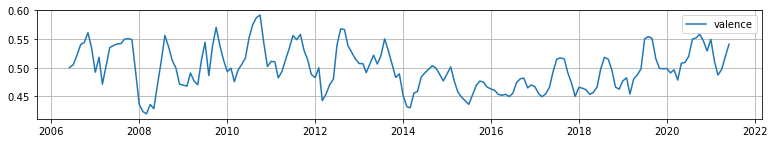

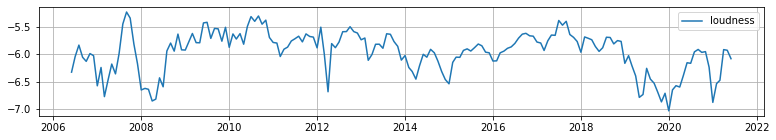

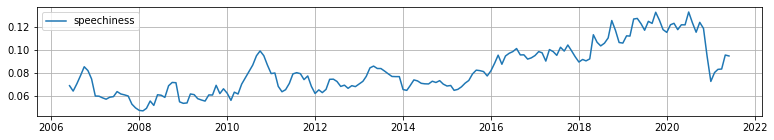

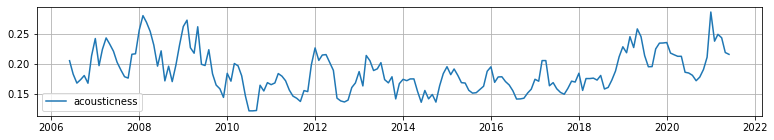

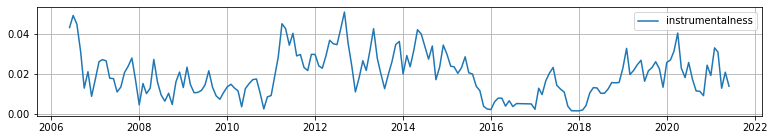

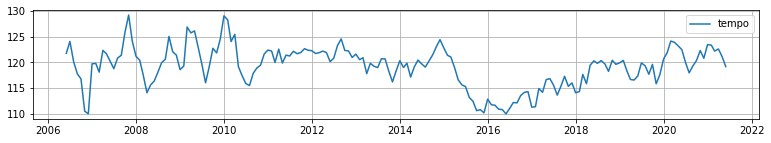

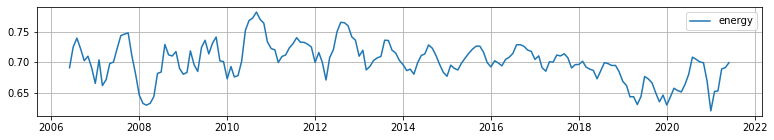

In [215]:
fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(danceability, label='danceability')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(valence, label='valence')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(loudness, label='loudness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(speechiness, label='speechiness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(acousticness, label='acousticness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(instrumentalness, label='instrumentalness')
plt.legend(loc='best')

#fig, ax = plt.subplots(figsize=(13,2))
#ax.grid(True)
#plt.plot(liveness, label='liveness')
#plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(tempo, label='tempo')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(energy, label='energy')
plt.legend(loc='best')

#fig, ax = plt.subplots(figsize=(13,2))
#ax.grid(True)
#plt.plot(mode, label='mode')
#plt.legend(loc='best')

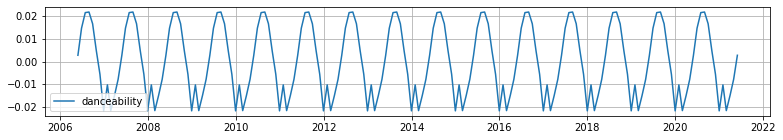

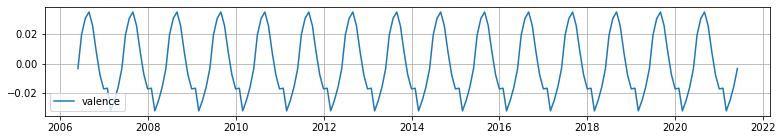

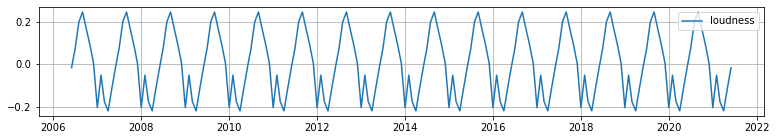

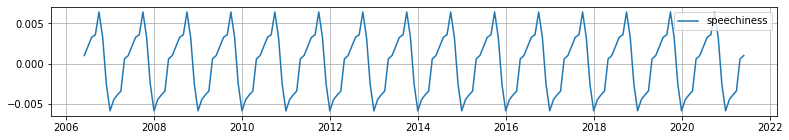

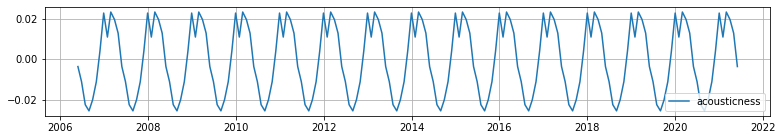

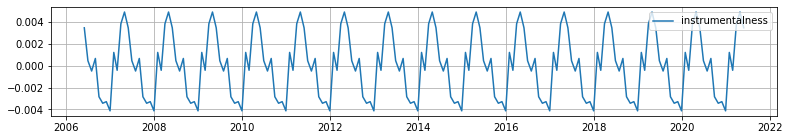

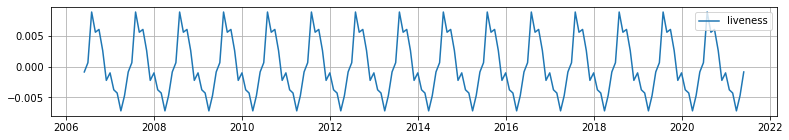

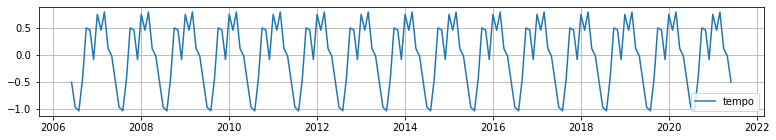

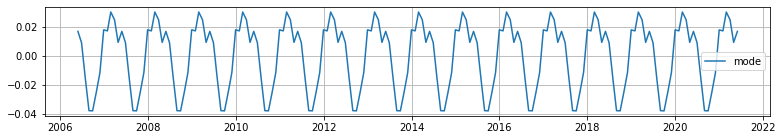

In [74]:
fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_danceability, label='danceability')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_valence, label='valence')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_loudness, label='loudness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_speechiness, label='speechiness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_acousticness, label='acousticness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_instrumentalness, label='instrumentalness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_liveness, label='liveness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_tempo, label='tempo')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_mode, label='mode')
plt.legend(loc='best')

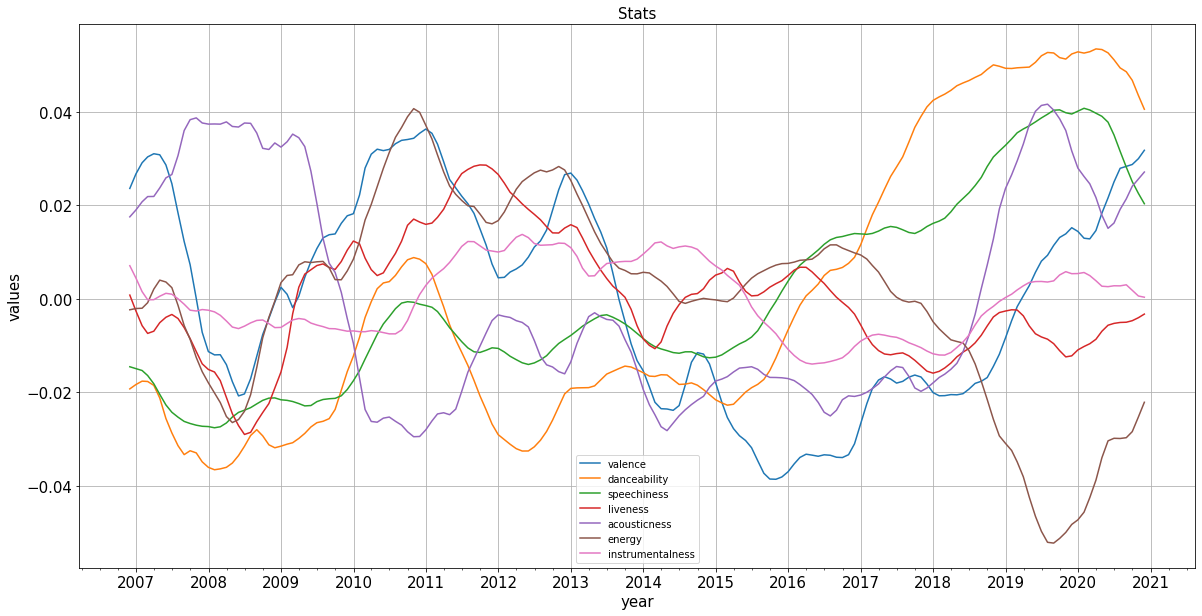

In [75]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(trend_valence - trend_valence.mean(), label="valence")
plt.plot(trend_danceability - trend_danceability.mean(), label="danceability")
plt.plot(trend_speechiness - trend_speechiness.mean(), label="speechiness")
plt.plot(trend_liveness - trend_liveness.mean(), label="liveness")
plt.plot(trend_acousticness - trend_acousticness.mean(), label="acousticness")
plt.plot(trend_energy - trend_energy.mean(), label="energy")
plt.plot(trend_instrumentalness - trend_instrumentalness.mean(), label="instrumentalness")

#plt.plot(trend_mode - trend_mode.mean(), label="mode")
#plt.plot(trend_loudness - trend_loudness.mean(), label="loudness")
#plt.plot(trend_tempo - trend_tempo.mean(), label="tempo")
#plt.plot(trend_explicit - trend_explicit.mean(), label="explicit")
#plt.plot(trend_duration - trend_duration.mean(), label="duration")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("values", fontsize=15)

#plt.savefig("stats.png", dpi=300)

plt.show()

# Seasonality

In [76]:
dfnoindex = df.reset_index()
dfnoindex

date_chart     original_song_name                original_artists_name  \
0     2006-05-07  svegliarsi la mattina                        zero assoluto   
1     2006-05-14  svegliarsi la mattina                        zero assoluto   
2     2006-05-21  svegliarsi la mattina                        zero assoluto   
3     2006-05-28  svegliarsi la mattina                        zero assoluto   
4     2006-06-04  svegliarsi la mattina                        zero assoluto   
...          ...                    ...                                  ...   
64407 2021-05-20                    boy   baby gang & bobo feat. rondodasosa   
64408 2021-05-20     cabriolet panorama                           the kolors   
64409 2021-05-20                 rapina           baby gang feat. neima ezza   
64410 2021-05-20               rasputin                  majestic & boney m.   
64411 2021-05-20      we are the people  martin garrix feat. bono & the edge   

       curr_rank        tag_fimi     publisher  song_id album_release_date  \
0              1             sgo           NaN        0         2006-02-28   
1              3             sgo           NaN        0         2006-02-28   
2              3             sgo           NaN        0         2006-02-28   
3              4             sgo           NaN        0         2006-02-28   
4              4             sgo           NaN        0         2006-02-28   
...          ...             ...           ...      ...                ...   
64407         76        wm italy  warner music     5858         1979-05-11   
64408         79          island           uni     5859         2021-04-29   
64409         88        wm italy  warner music     5860         2021-05-14   
64410         90    nitron music           sme     5861               1978   
64411         93  epic amsterdam       sme/uni     5862         2021-05-14   

      album_type                                          song_name  ...  \
0         single                              Svegliarsi la mattina  ...   
1         single                              Svegliarsi la mattina  ...   
2         single                              Svegliarsi la mattina  ...   
3         single                              Svegliarsi la mattina  ...   
4         single                              Svegliarsi la mattina  ...   
...          ...                                                ...  ...   
64407      album                                     Boys Don't Cry  ...   
64408     single                                 Cabriolet Panorama  ...   
64409      album                          Rapina (feat. Neima Ezza)  ...   
64410      album                                           Rasputin  ...   
64411     single  We Are The People (feat. Bono & The Edge) - Of...  ...   

         tempo            type                      id  \
0      171.970  audio_features  1ecMdfIXNksJTymYlzsFZ3   
1      171.970  audio_features  1ecMdfIXNksJTymYlzsFZ3   
2      171.970  audio_features  1ecMdfIXNksJTymYlzsFZ3   
3      171.970  audio_features  1ecMdfIXNksJTymYlzsFZ3   
4      171.970  audio_features  1ecMdfIXNksJTymYlzsFZ3   
...        ...             ...                     ...   
64407  168.766  audio_features  1QFh8OH1e78dGd3VyJZCAC   
64408  116.012  audio_features  4lajqBJavxKL3sllt1TcTH   
64409   77.653  audio_features  6DQeNYWn9lbwxeYAXzu7IE   
64410  126.143  audio_features  5jkFvD4UJrmdoezzT1FRoP   
64411  119.933  audio_features  2iL0W5qi0ivZ9WRXbZ74cS   

                                                     uri  \
0      https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
1      https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
2      https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
3      https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
4      https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
...                                                  ...   
64407               spotify:track:1QFh8OH1e78dGd3VyJZCAC   
64408  https://api

In [77]:
noindex_danceability = seasonal_danceability.reset_index()
noindex_valence = seasonal_valence.reset_index()
noindex_duration = seasonal_duration.reset_index()
noindex_energy = seasonal_energy.reset_index()
noindex_loudness = seasonal_loudness.reset_index()
noindex_speechiness = seasonal_speechiness.reset_index()
noindex_mode = seasonal_mode.reset_index()
noindex_acousticness = seasonal_acousticness.reset_index()
noindex_instrumentalness = seasonal_instrumentalness.reset_index()
noindex_liveness = seasonal_liveness.reset_index()
noindex_tempo = seasonal_tempo.reset_index()

## Danceability

C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

Text(0, 0.5, 'Danceability')

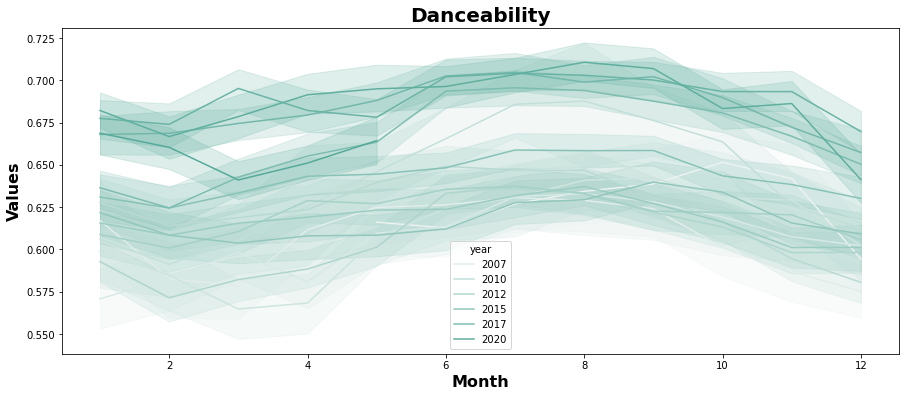

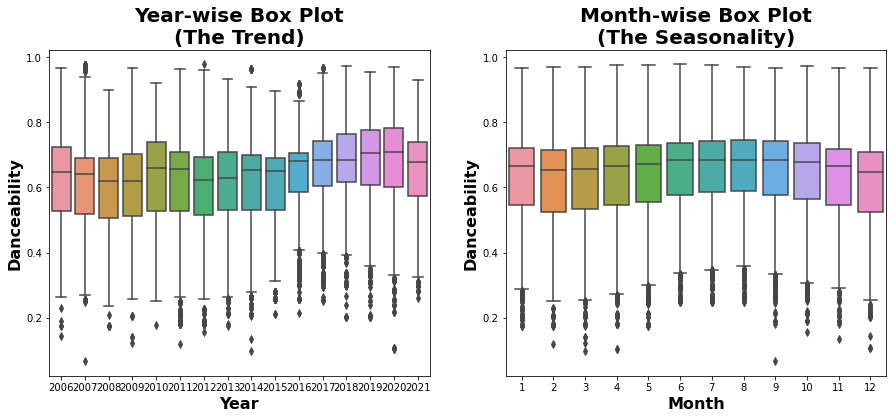

In [78]:
variable = 'danceability'
fig, ax = plt.subplots(figsize=(15, 6))

#palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
palette = sns.color_palette("light:#5A9", as_cmap=True)
sns.lineplot(dfnoindex['month'], dfnoindex[variable], hue=dfnoindex['year'], palette=palette)
ax.set_title('Danceability', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Values', fontsize = 16, fontdict=dict(weight='bold'))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(dfnoindex['year'], dfnoindex[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Danceability', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(dfnoindex['month'], dfnoindex[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Danceability', fontsize = 16, fontdict=dict(weight='bold'))

C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Danceability')

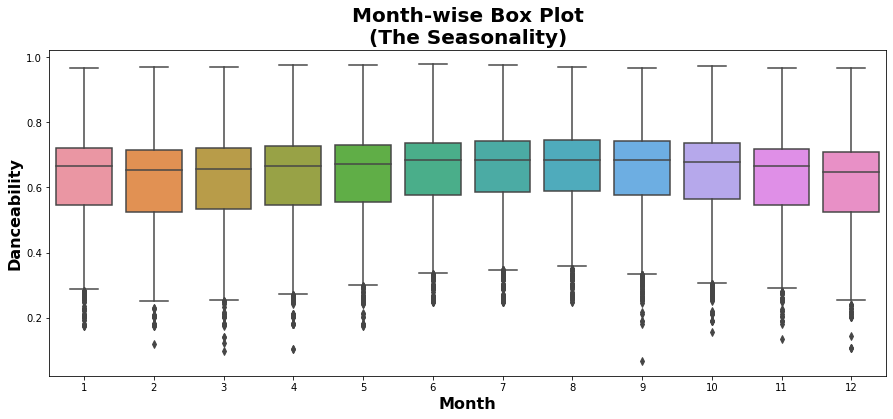

In [79]:
variable = "danceability"

fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(dfnoindex['month'], dfnoindex[variable])
ax.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Danceability', fontsize = 16, fontdict=dict(weight='bold'))

In [80]:
#Questa è la stagionalità decomposta

noindex_danceability = seasonal_danceability.reset_index()
noindex_danceability

date_chart  seasonal
0   2006-05-31  0.002732
1   2006-06-30  0.014597
2   2006-07-31  0.021420
3   2006-08-31  0.021677
4   2006-09-30  0.016533
..         ...       ...
176 2021-01-31 -0.010242
177 2021-02-28 -0.021511
178 2021-03-31 -0.014898
179 2021-04-30 -0.007796
180 2021-05-31  0.002732

[181 rows x 2 columns]

<AxesSubplot:xlabel='date_chart'>

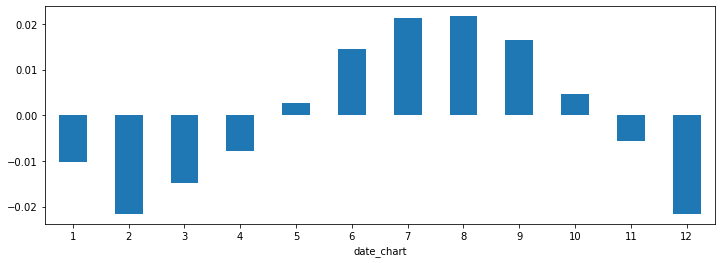

In [81]:
fig, axs = plt.subplots(figsize=(12, 4))

noindex_danceability.groupby(noindex_danceability["date_chart"].dt.month)["seasonal"].mean().plot(kind='bar', rot=0, ax=axs)

In [129]:
alt.Chart(noindex_danceability).mark_line(color='firebrick', strokeWidth=3).encode(
    x=alt.X('yearmonth(date_chart):T', axis=alt.Axis(title='Months')),
    y=alt.Y('seasonal:Q', axis=alt.Axis(title='Values'))
).properties(width=700, height=300, title="Danceability")

alt.Chart(...)

#### Tutte le seasonality

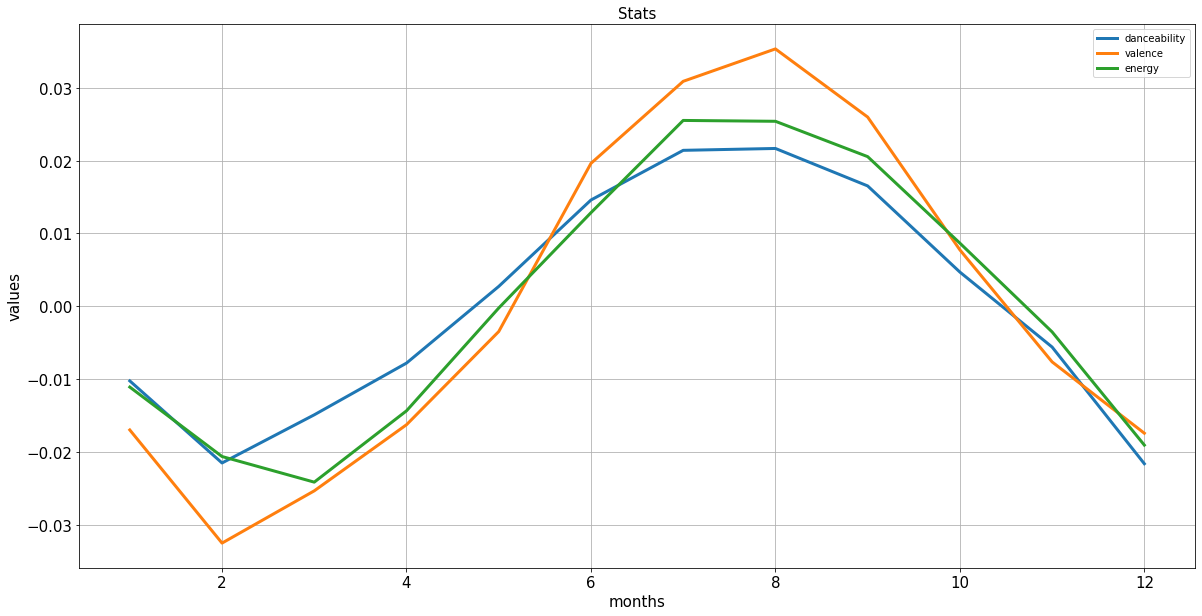

In [221]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

plt.plot(noindex_danceability.groupby(noindex_danceability["date_chart"].dt.month)["seasonal"].mean(), linewidth=3, label="danceability")
plt.plot(noindex_valence.groupby(noindex_valence["date_chart"].dt.month)["seasonal"].mean(), linewidth=3, label="valence")
plt.plot(noindex_energy.groupby(noindex_energy["date_chart"].dt.month)["seasonal"].mean(), linewidth=3, label="energy")
#plt.plot(noindex_loudness.groupby(noindex_loudness["date_chart"].dt.month)["seasonal"].mean(), label="loudness")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("months", fontsize=15)
ax.set_ylabel("values", fontsize=15)

#plt.savefig("stats.png", dpi=300)

plt.show()

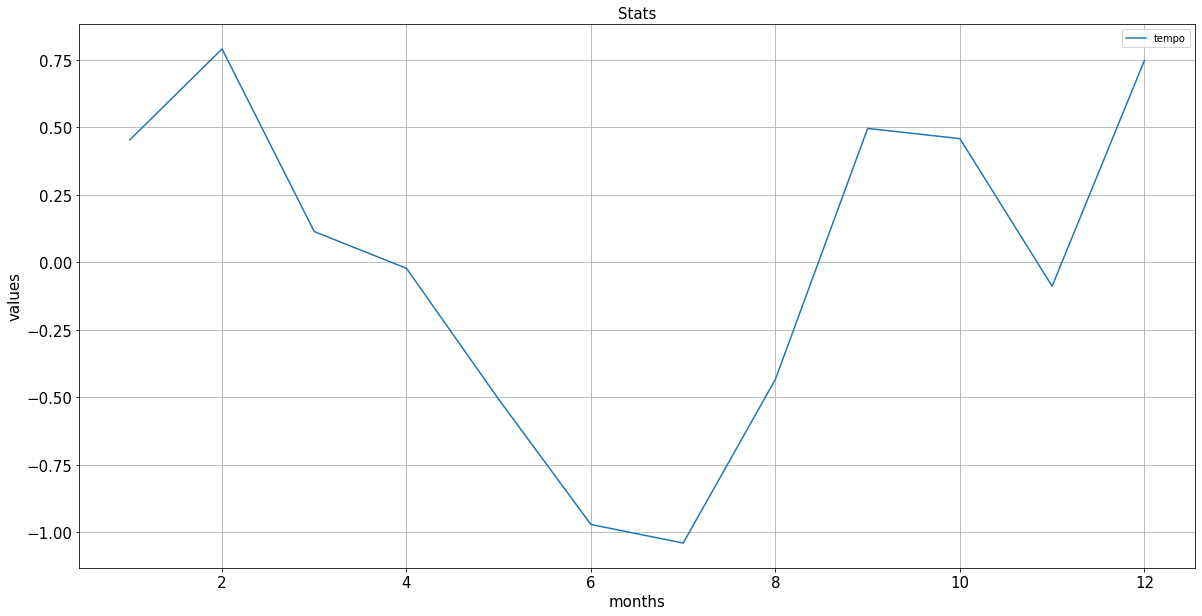

In [246]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

#year = mdates.YearLocator(month=1)
#month = mdates.MonthLocator(interval=3)

#ax.xaxis.set_minor_locator(month)
#ax.xaxis.set_major_locator(year)


#plt.plot(noindex_danceability.groupby(noindex_danceability["date_chart"].dt.month)["seasonal"].mean(), label="danceability")
#plt.plot(noindex_valence.groupby(noindex_valence["date_chart"].dt.month)["seasonal"].mean(), label="valence")
#plt.plot(noindex_energy.groupby(noindex_energy["date_chart"].dt.month)["seasonal"].mean(), label="energy")
#plt.plot(noindex_loudness.groupby(noindex_loudness["date_chart"].dt.month)["seasonal"].mean(), label="loudness")

#plt.plot(noindex_speechiness.groupby(noindex_speechiness["date_chart"].dt.month)["seasonal"].mean(), label="speechiness")
#plt.plot(noindex_acousticness.groupby(noindex_acousticness["date_chart"].dt.month)["seasonal"].mean(), label="acousticness")
#plt.plot(noindex_instrumentalness.groupby(noindex_instrumentalness["date_chart"].dt.month)["seasonal"].mean(), label="instrumentalness")
plt.plot(noindex_tempo.groupby(noindex_tempo["date_chart"].dt.month)["seasonal"].mean(), label="tempo")

#plt.plot(noindex_liveness.groupby(noindex_liveness["date_chart"].dt.month)["seasonal"].mean(), label="liveness")
#plt.plot(noindex_mode.groupby(noindex_mode["date_chart"].dt.month)["seasonal"].mean(), label="mode")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("months", fontsize=15)
ax.set_ylabel("values", fontsize=15)

#plt.savefig("stats.png", dpi=300)

plt.show()

# Plots used for the interview to Bonalume and Varini

### Duration

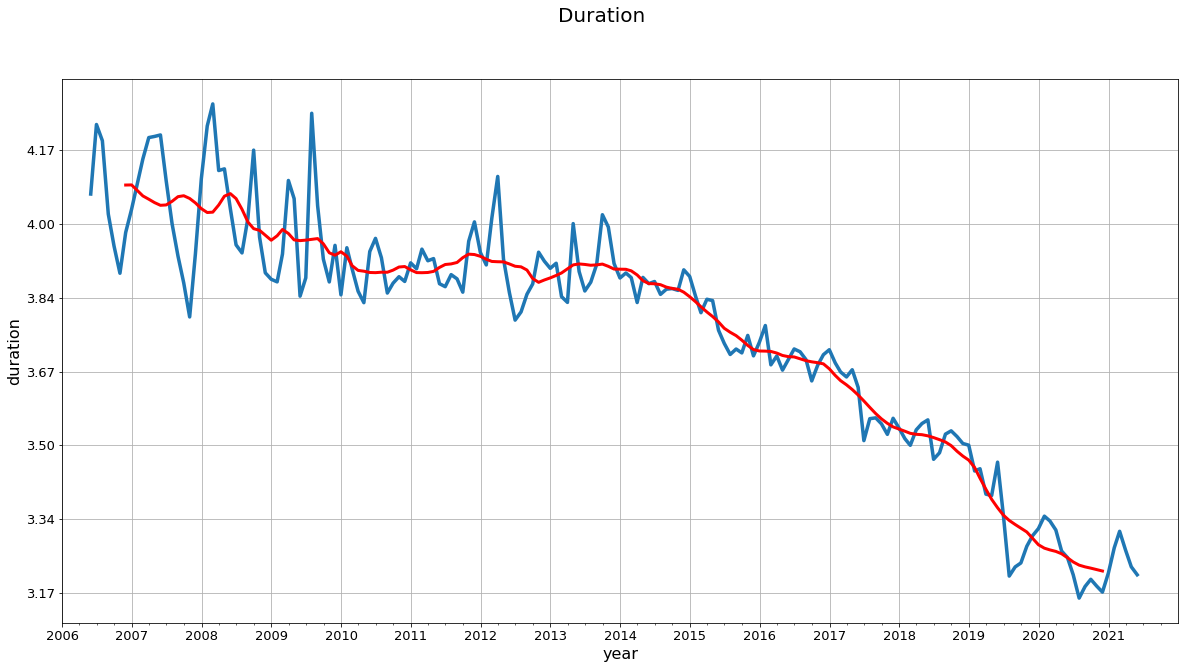

In [244]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

fig.suptitle('Duration', fontsize=20)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)
ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.plot(duration.index, duration, linewidth=3.5)
plt.plot(trend_duration.index, trend_duration, c='red', linewidth=3)

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(Decimal(str(x/60000)).quantize(Decimal('.01'), rounding=ROUND_UP)))
ax.yaxis.set_major_formatter(ticks)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 

plt.xlabel('year', fontsize=16)
plt.ylabel('duration', fontsize=16)

plt.savefig("duration.png", dpi=300, facecolor='w')

### Danceability, speechiness

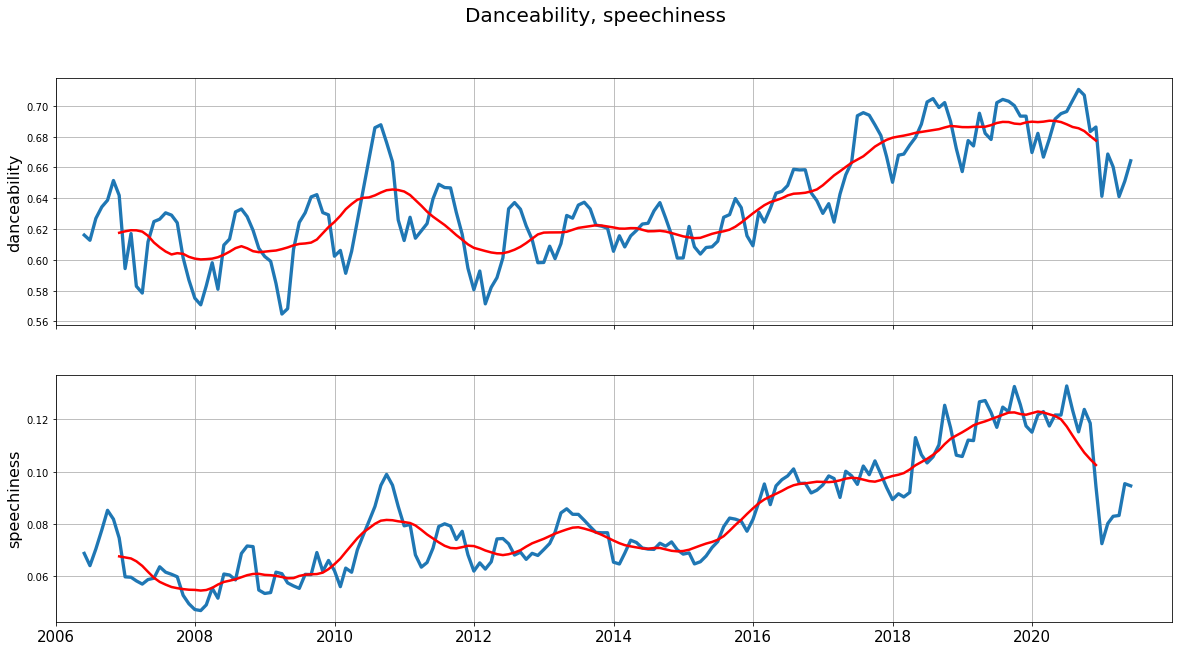

In [218]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20,10))


fig.suptitle('Danceability, speechiness', fontsize=20)

ax1.plot(danceability, label='danceability', linewidth=3.3)
ax1.grid(True)
ax1.set_ylabel('danceability',fontsize=16)
ax1.plot(trend_danceability.index, trend_danceability, c='red', linewidth=2.5)


ax2.plot(speechiness, label='speechiness', linewidth=3.3)
ax2.grid(True)
ax2.set_ylabel('speechiness',fontsize=16)
ax2.plot(trend_speechiness.index, trend_speechiness, c='red', linewidth=2.5)
ax2.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.xticks(fontsize=15) 

plt.savefig("danceability_speechiness.png", dpi=300, facecolor='w')

### Tempo, instrumentalness, valence

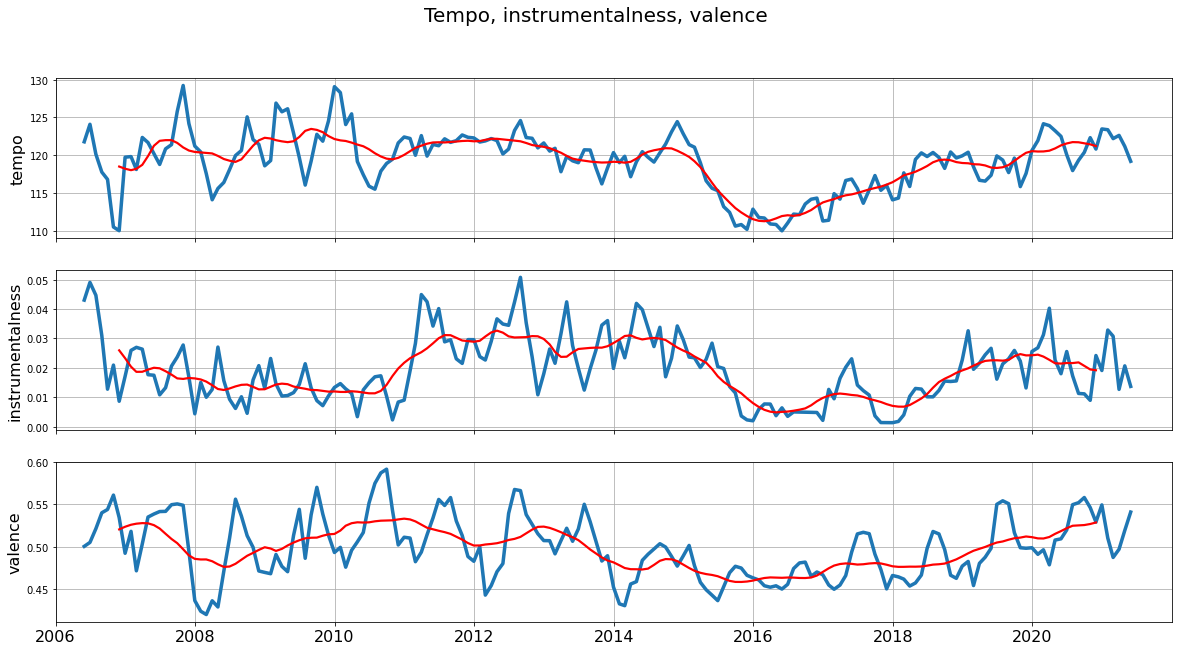

In [185]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))

fig.suptitle('Tempo, instrumentalness, valence', fontsize=20)


ax1.plot(tempo, label='tempo', linewidth=3.5)
ax1.grid(True)
ax1.set_ylabel('tempo',fontsize=16)
ax1.set_ylabel('tempo',fontsize=16)
ax1.plot(trend_tempo.index, trend_tempo, c='red', linewidth=2.2)

ax2.plot(instrumentalness, label='instrumentalness', linewidth=3.5)
ax2.grid(True)
ax2.set_ylabel('instrumentalness',fontsize=16)
ax2.plot(trend_instrumentalness.index, trend_instrumentalness, c='red', linewidth=2.2)

ax3.plot(valence, label='valence', linewidth=3.5)
ax3.grid(True)
ax3.set_ylabel('valence', fontsize=16)
ax3.set_ylabel('valence',fontsize=16)
ax3.plot(trend_valence.index, trend_valence, c='red', linewidth=2.2)
ax3.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.xticks(fontsize=16)

plt.savefig("Tempo_instrumentalness_valence.png", dpi=300, facecolor='w')

plt.show()


### acousticness, energy, loudness

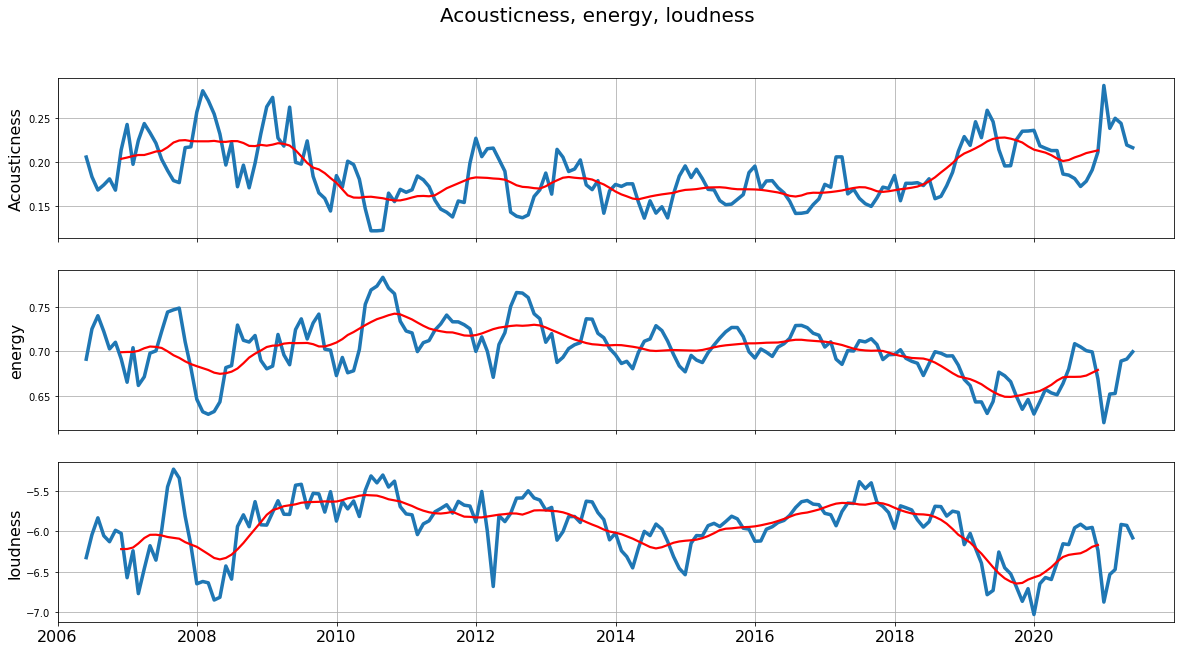

In [217]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))

fig.suptitle('Acousticness, energy, loudness', fontsize=20)


ax1.plot(acousticness, label='Acousticness', linewidth=3.5)
ax1.grid(True)
ax1.set_ylabel('Acousticness',fontsize=16)
ax1.set_ylabel('Acousticness',fontsize=16)
ax1.plot(trend_acousticness.index, trend_acousticness, c='red', linewidth=2.2)

ax2.plot(energy, label='energy', linewidth=3.5)
ax2.grid(True)
ax2.set_ylabel('energy',fontsize=16)
ax2.plot(trend_energy.index, trend_energy, c='red', linewidth=2.2)

ax3.plot(loudness, label='loudness', linewidth=3.5)
ax3.grid(True)
ax3.set_ylabel('loudness', fontsize=16)
ax3.set_ylabel('loudness',fontsize=16)
ax3.plot(trend_loudness.index, trend_loudness, c='red', linewidth=2.2)
ax3.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.xticks(fontsize=16)

plt.savefig("Acousticness, energy, loudness.png", dpi=300, facecolor='w')

plt.show()

### Number of artists per song

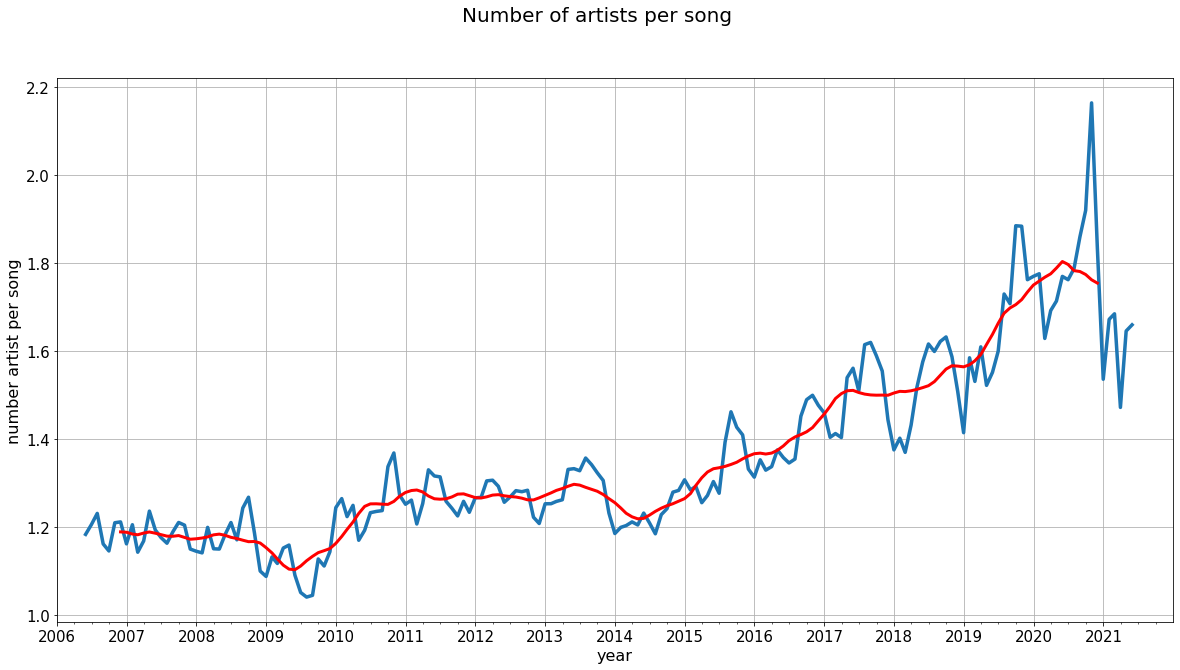

In [223]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

fig.suptitle('Number of artists per song', fontsize=20)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)
ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.plot(number_artist.index, number_artist, linewidth=3.5)
plt.plot(trend_number_artist.index, trend_number_artist, c='red', linewidth=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('year', fontsize=16)
plt.ylabel('number artist per song', fontsize=16)

plt.savefig("number_artists_song.png", dpi=300, facecolor='w')

plt.show()

### Explicit

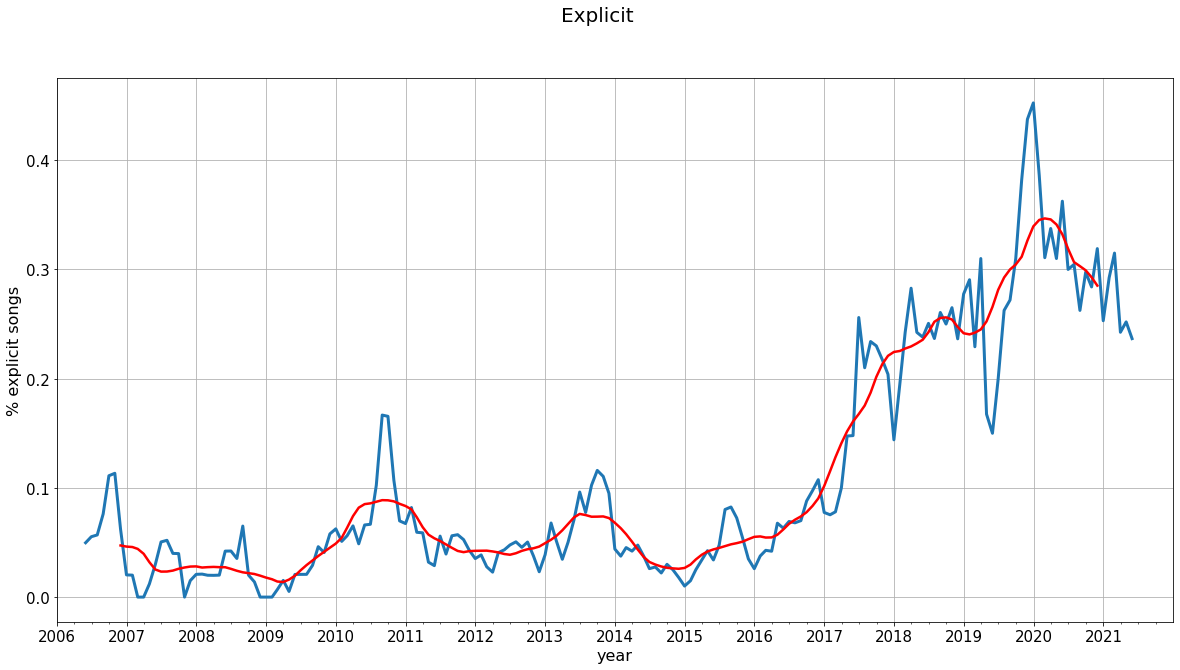

In [220]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

fig.suptitle('Explicit', fontsize=20)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)
ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.plot(explicit.index, explicit, linewidth=3)
plt.plot(trend_explicit.index, trend_explicit, c='red', linewidth=2.5)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('year', fontsize=16)
plt.ylabel('% explicit songs', fontsize=16)

plt.savefig("explicit.png", dpi=300, facecolor='w')